# Introduction  

Ce travail a été réalisé dans le cadre de mon stage et avait pour objectif d’**étudier la forme musculaire de sujets sarcopéniques** à l’aide de la méthode des *Statistical Shape Models (SSM)*.  
L’approche repose sur la modélisation statistique de formes anatomiques afin d’analyser les variations structurelles et de comparer des populations de sujets sains et pathologiques.  

Au cours de cette étude, plusieurs méthodes ont été mises en œuvre pour explorer et caractériser les données :  

- **Séparation par LDA (Linear Discriminant Analysis)** : afin de projeter les données dans un espace optimisé pour la discrimination entre groupes.  
- **Détection d’anomalies** :  
  - Analyse de l’**erreur de reconstruction** à partir du modèle statistique.  
  - Évaluation des performances par **LDA train/test**.  
  - Mise en place d’une **classification supervisée** pour distinguer les sujets sarcopéniques des autres.  

Ces méthodes combinées permettent d’évaluer la pertinence du modèle statistique pour l’analyse des variations morphologiques musculaires et d’explorer son potentiel comme outil d’aide au diagnostic.  


## Correspondance des points  

La correspondance des points est une étape essentielle dans la construction d’un *Statistical Shape Model (SSM)*.  
Elle consiste à établir un alignement cohérent entre les formes en associant des points homologues (landmarks) d’un sujet à l’autre.  
Cette étape garantit que les variations observées reflètent uniquement des différences anatomiques, et non des décalages dus à un mauvais appariement des points.  

Dans le cadre de ce travail, la mise en correspondance des points n’a pas été réalisée ici directement.  
Cette partie avait déjà été effectuée par des stagiaires précédents et est disponible dans un autre notebook, qui sert de base aux analyses présentées dans ce document.  


# Import

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss,auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score, precision_score


def get_particles(particles_dir, particle_type="world"):
    particles = []
    names = []
    for filename in os.listdir(particles_dir):
        if filename.endswith(particle_type + ".particles"):
            data = np.loadtxt(os.path.join(particles_dir, filename))
            particles.append(data)
            names.append(os.path.splitext(filename)[0])
    if not particles:
        return None, None
    return np.array(particles), names

def compute_fisher_score(lda_projection_128, label_128):
    # Calcule le score de Fisher pour la projection LDA
    X = lda_projection_128  # projection LDA (n_samples, n_components)
    y = label_128           # labels (n_samples,)

    classes = np.unique(y)
    n_classes = len(classes)
    overall_mean = np.mean(X, axis=0)

    # Matrices de dispersion inter-classes et intra-classes
    S_B = np.zeros((X.shape[1], X.shape[1]))
    S_W = np.zeros((X.shape[1], X.shape[1]))

    for cls in classes:
        X_c = X[y == cls]
        mean_c = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]
    
        # S_B: between-class scatter
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)

        # S_W: within-class scatter
        cov_c = np.cov(X_c, rowvar=False)  # (d, d)
        S_W += cov_c * (n_c - 1)

    # Ratio de Fisher généralisé
    fisher_score_multi = np.trace(S_B) / np.trace(S_W)

    # Calcul des valeurs propres pour le score exact
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
    fisher_score_exact = np.mean(eigvals)
    return fisher_score_exact

def train_test_label(particules_train, particules_test):
    # Génère les labels pour les fichiers de particules d'entraînement et de test
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * 24))  # Ajoute 24 labels pour les particules de test sarcopénie
    return train_label, test_label




[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------------------------------------- - 286.7/294.9 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# RF
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Sarcopenie_128"


# Train
particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train"

# Test
particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test"



Récupérations des fichiers de points de correpondance

In [3]:
# Chargement des particules pour chaque groupe
sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # n: sujets, p: points, d: dimensions
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)

vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Chargement des particules de test et aplatissement
test_parts_128, test_names = get_particles(particles_dir_test, "world")
n, p, d = test_parts_128.shape
test_parts_flat_128 = test_parts_128.reshape(n, -1)

# Chargement des particules d'entraînement et aplatissement
train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
n, p, d = train_parts_128.shape
train_parts_flat_128 = train_parts_128.reshape(n, -1)

# Création des labels pour l'entraînement et le test
train_label, test_label = train_test_label(particles_dir_train, particles_dir_test)


# Métriques SSM


Afin d’évaluer la qualité et la pertinence du *Statistical Shape Model (SSM)*, trois métriques classiques ont été utilisées :  

- **Compacité** : mesure la capacité du modèle à représenter les variations de forme avec un nombre réduit de composantes principales.  
- **Généralisation** : évalue la capacité du modèle à reconstruire correctement de nouvelles formes qui n’ont pas été utilisées lors de la construction du modèle.  
- **Spécificité** : vérifie que les formes générées par le modèle sont réalistes et proches de celles observées dans les données réelles.  


## Avec Sarcopénie

### Compactness

In [9]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

import numpy as np
from tqdm import tqdm
from colorama import Fore



sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

n_remove = 23
print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Répartition aléatoire du nombre à supprimer dans A et B
nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
b = n_remove - a

# Supprimer a sujets de A et b sujets de B
jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)

accuracy_tot=[]

for i in range(5):
    # Combine data for jeunes and vieux
    
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128,sarcopenie_parts_flat_128))
    # Remove 23 random samples
    
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128)+ [2] * len(sarcopenie_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie


   # PCA
    pca = PCA()
    pca.fit(parts_flat_128)
    eigenvalues = pca.explained_variance_
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues)
    compacity = cumulative_variance / total_variance
    # print(compacity[:10])
    # Trouver le nombre de composantes nécessaires pour atteindre le seuil
    threshold=0.95
    n_components_95 = np.searchsorted(compacity, threshold) + 1
    # print(n_components_95)
    accuracy_tot.append(n_components_95)

print(f"Taille de la matrice : {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(f"nb composante pour 95% de l'info : {np.mean(accuracy_tot)}")

(45, 384) (35, 384)
(25, 384) (32, 384)
Taille de la matrice : 81 samples, 384 features
nb composante pour 95% de l'info : 8.0


### Généralisation

In [10]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

def compute_generalization(real_shapes, num_particles):
    print("  Calcul Generalization...", Fore.YELLOW)
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n, p, dim3 = real_shapes.shape
        d = p * dim3
        real_shapes_2d = real_shapes.reshape(n, d)
    else:
        n, d = real_shapes.shape
        real_shapes_2d = real_shapes

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    P = real_shapes_2d.T
    gens = np.zeros(n - 1)

    for m in range(1, n):
        tot_dist = 0.0
        for leave in range(n):
            Y = np.zeros((P.shape[0], n-1))
            Y[:, :leave] = P[:, :leave]
            Y[:, leave:] = P[:, leave+1:]
            mu = np.mean(Y, axis=1, keepdims=True)
            Yc = Y - mu
            U, S, _ = np.linalg.svd(Yc, full_matrices=False)
            epsi = U[:, :m]

            ytest = P[:, leave:leave+1]
            betas = epsi.T @ (ytest - mu)
            rec = epsi @ betas + mu

            dist = shape_distance(rec, ytest, num_particles) / float(num_particles)
            tot_dist += dist
        gens[m - 1] = tot_dist / float(n)

    return gens


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  


# # Génération des nouvelles observations synthétiques
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augmente x2 les jeunes
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augmente x2 les vieux
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augmente x2 la sarcopénie

accuracy_tot=[]
n_remove = 23
print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Répartition aléatoire du nombre à supprimer dans A et B
nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
b = n_remove - a

# Supprimer a sujets de A et b sujets de B
jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Combine data for jeunes and vieux
parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128,sarcopenie_parts_flat_128))
label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128)+ [2] * len(sarcopenie_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
# print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

# Split data into training and testing sets (80% train, 20% test)
X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)#, random_state=42)
# X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
# X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
# print(f"nb enssemble train : {len(X_train_64)}, nb ensemble test: {len(X_test_64)}")
# print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")


count_jeunes=0
count_vieux=0
count_sarcopenie=0
for i in y_train_128:
    if i==0:
        count_jeunes+=1
    elif i==1:
        count_vieux+=1
    elif i==2:
        count_sarcopenie+=1
# print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

count_jeunes=0
count_vieux=0
count_sarcopenie=0
for i in y_test_128:
    if i==0:
        count_jeunes+=1
    elif i==1:
        count_vieux+=1
    elif i==2:
        count_sarcopenie+=1
# print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

# Train PCA on the training data
# Adjust n_components to be less than or equal to min(n_samples, n_features)

max_components = min(X_train_128.shape[0], X_train_128.shape[1])
scores_64 = []
scores_128 = []
k_neighbors = 5  # Nombre de voisins pour le kNN
cv_folds = 20  # Nombre de folds pour la validation croisée


# print(f"Training PCA with {max_components} components")
component_range = range(2, max_components + 1, 2) 

pca_128 = PCA(n_components=max_components)
X_pca_128 = pca_128.fit_transform(X_train_128)



# Ensure n_components for LDA is valid
score=compute_generalization(parts_flat_128, 128)[-1]
# score=compute_generalization(parts_flat_128, 256)[-1]
print(f"taille de la matrice : {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(score)



(45, 384) (35, 384)
(29, 384) (28, 384)
  Calcul Generalization... 
taille de la matrice : 81 samples, 384 features
0.43149350758232463


### Specificity

In [11]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


def compute_specificity(real_shapes, num_particles, num_samples=1000):
    print("  Calcul Specificity...", Fore.YELLOW)
    # Reshape des données d'entraînement
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n_train, p, _ = real_shapes.shape
        d = p * 3
        real_shapes_2d = real_shapes.reshape(n_train, d)
    else:
        n_train, d = real_shapes.shape
        real_shapes_2d = real_shapes

    
    Y = real_shapes_2d.T
    mu = np.mean(Y, axis=1, keepdims=True)
    Yc = Y - mu
    U, S, _ = np.linalg.svd(Yc, full_matrices=False)
    if S[0] < S[-1]:
        S = S[::-1]
        U = np.fliplr(U)

    specifics = np.zeros(n - 1)

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    for m in tqdm(range(1, n), desc="  Specificity modes"):
        epsi = U[:, :m]
        stdevs = np.sqrt(S[:m])
        betas = np.random.randn(m, num_samples)
        for i_mode in range(m):
            betas[i_mode, :] *= stdevs[i_mode]
        synth = epsi @ betas + mu
        min_dists = np.zeros(num_samples)
        for isyn in range(num_samples):
            sy = synth[:, isyn]
            best = 1e15
            for j in range(n):
                dist_j = shape_distance(sy, Y[:, j], num_particles)
                if dist_j < best:
                    best = dist_j
            min_dists[isyn] = best
        specifics[m-1] = np.mean(min_dists) / float(num_particles)

    return specifics


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  

n_remove = 23
print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Répartition aléatoire du nombre à supprimer dans A et B
nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
b = n_remove - a

# Supprimer a sujets de A et b sujets de B
jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
accuracy_tot=[]
for i in range(1):

    # Combine data for jeunes and vieux
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128,sarcopenie_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128)+ [2] * len(sarcopenie_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2)#, random_state=42)
    # X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
    # X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
    # print(f"nb enssemble train : {len(X_train_128)}, nb ensemble test: {len(X_test_128)}")
    # print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")


    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Nombre de voisins pour le kNN
    cv_folds = 20  # Nombre de folds pour la validation croisée


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2) 

    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)



    # Ensure n_components for LDA is valid
    score=compute_specificity(parts_flat_128, 128,1000)[-1]
    # score=compute_specificity(parts_flat_128, 256,1000)[-1]

    # print(score)
    accuracy_tot.append(score)
print(f"taille de la matrice : {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

print(f"erreur de reconstruction moy : {np.mean(accuracy_tot)}")
print(f"erreur de reconstruction std : {np.std(accuracy_tot)}")

(45, 384) (35, 384)
(34, 384) (23, 384)
  Calcul Specificity... 


  Specificity modes: 100%|██████████| 34/34 [00:17<00:00,  1.98it/s]

taille de la matrice : 81 samples, 384 features
erreur de reconstruction moy : 4.435613198502593
erreur de reconstruction std : 0.0


## Sans Sarcopénie

### Compactness

In [ ]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

import numpy as np
from tqdm import tqdm
from colorama import Fore



sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  


# # Génération des nouvelles observations synthétiques
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augmente x2 les jeunes
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augmente x2 les vieux
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augmente x2 la sarcopénie

accuracy_tot=[]

for i in range(5):
    # Combine data for jeunes and vieux
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.05)#, random_state=42)
    # X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
    # X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
    X_test_128 = np.vstack((sarcopenie_parts_flat_128, X_test_128))
    # print(f"nb enssemble train : {len(X_train_128)}, nb ensemble test: {len(X_test_128)}")
    # print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")

    # X_train_128 = parts_flat_128
    


    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Nombre de voisins pour le kNN
    cv_folds = 20  # Nombre de folds pour la validation croisée


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2) 

    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)



   # PCA
    pca = PCA()
    pca.fit(parts_flat_128)
    eigenvalues = pca.explained_variance_
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues)
    compacity = cumulative_variance / total_variance
    # print(compacity[:10])
    # Trouver le nombre de composantes nécessaires pour atteindre le seuil
    threshold=0.95
    n_components_95 = np.searchsorted(compacity, threshold) + 1
    # print(n_components_95)
    accuracy_tot.append(n_components_95)

print(f"Taille de la matrice : {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(f"nb composante pour 95% de l'info : {np.mean(accuracy_tot)}")

Taille de la matrice : 78 samples, 384 features
nb composante pour 95% de l'info : 9.0


### Generalisation

In [6]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

def compute_generalization(real_shapes, num_particles):
    print("  Calcul Generalization...", Fore.YELLOW)
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n, p, dim3 = real_shapes.shape
        d = p * dim3
        real_shapes_2d = real_shapes.reshape(n, d)
    else:
        n, d = real_shapes.shape
        real_shapes_2d = real_shapes

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    P = real_shapes_2d.T
    gens = np.zeros(n - 1)

    for m in range(1, n):
        tot_dist = 0.0
        for leave in range(n):
            Y = np.zeros((P.shape[0], n-1))
            Y[:, :leave] = P[:, :leave]
            Y[:, leave:] = P[:, leave+1:]
            mu = np.mean(Y, axis=1, keepdims=True)
            Yc = Y - mu
            U, S, _ = np.linalg.svd(Yc, full_matrices=False)
            epsi = U[:, :m]

            ytest = P[:, leave:leave+1]
            betas = epsi.T @ (ytest - mu)
            rec = epsi @ betas + mu

            dist = shape_distance(rec, ytest, num_particles) / float(num_particles)
            tot_dist += dist
        gens[m - 1] = tot_dist / float(n)

    return gens


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  


# # Génération des nouvelles observations synthétiques
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augmente x2 les jeunes
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augmente x2 les vieux
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augmente x2 la sarcopénie

accuracy_tot=[]

# Combine data for jeunes and vieux
parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
# print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

# Split data into training and testing sets (80% train, 20% test)
X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)#, random_state=42)
# X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
# X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
# print(f"nb enssemble train : {len(X_train_64)}, nb ensemble test: {len(X_test_64)}")
# print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")


count_jeunes=0
count_vieux=0
count_sarcopenie=0
for i in y_train_128:
    if i==0:
        count_jeunes+=1
    elif i==1:
        count_vieux+=1
    elif i==2:
        count_sarcopenie+=1
# print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

count_jeunes=0
count_vieux=0
count_sarcopenie=0
for i in y_test_128:
    if i==0:
        count_jeunes+=1
    elif i==1:
        count_vieux+=1
    elif i==2:
        count_sarcopenie+=1
# print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

# Train PCA on the training data
# Adjust n_components to be less than or equal to min(n_samples, n_features)

max_components = min(X_train_128.shape[0], X_train_128.shape[1])
scores_64 = []
scores_128 = []
k_neighbors = 5  # Nombre de voisins pour le kNN
cv_folds = 20  # Nombre de folds pour la validation croisée


# print(f"Training PCA with {max_components} components")
component_range = range(2, max_components + 1, 2) 

pca_128 = PCA(n_components=max_components)
X_pca_128 = pca_128.fit_transform(X_train_128)



# Ensure n_components for LDA is valid
print(f"taille de la matrice : {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
score=compute_generalization(parts_flat_128, 128)[-1]
# score=compute_generalization(parts_flat_128, 256)[-1]

print(score)



taille de la matrice : 80 samples, 384 features
  Calcul Generalization... 
0.41365514948610355


### Specificity

In [ ]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


def compute_specificity(real_shapes, num_particles, num_samples=1000):
    print("  Calcul Specificity...", Fore.YELLOW)
    # Reshape des données d'entraînement
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n_train, p, _ = real_shapes.shape
        d = p * 3
        real_shapes_2d = real_shapes.reshape(n_train, d)
    else:
        n_train, d = real_shapes.shape
        real_shapes_2d = real_shapes

    
    Y = real_shapes_2d.T
    mu = np.mean(Y, axis=1, keepdims=True)
    Yc = Y - mu
    U, S, _ = np.linalg.svd(Yc, full_matrices=False)
    if S[0] < S[-1]:
        S = S[::-1]
        U = np.fliplr(U)

    specifics = np.zeros(n - 1)

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    for m in tqdm(range(1, n), desc="  Specificity modes"):
        epsi = U[:, :m]
        stdevs = np.sqrt(S[:m])
        betas = np.random.randn(m, num_samples)
        for i_mode in range(m):
            betas[i_mode, :] *= stdevs[i_mode]
        synth = epsi @ betas + mu
        min_dists = np.zeros(num_samples)
        for isyn in range(num_samples):
            sy = synth[:, isyn]
            best = 1e15
            for j in range(n):
                dist_j = shape_distance(sy, Y[:, j], num_particles)
                if dist_j < best:
                    best = dist_j
            min_dists[isyn] = best
        specifics[m-1] = np.mean(min_dists) / float(num_particles)

    return specifics


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  


# # Génération des nouvelles observations synthétiques
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augmente x2 les jeunes
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augmente x2 les vieux
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augmente x2 la sarcopénie

accuracy_tot=[]
for i in range(1):

    # Combine data for jeunes and vieux
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2)#, random_state=42)
    # X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
    # X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
    # print(f"nb enssemble train : {len(X_train_128)}, nb ensemble test: {len(X_test_128)}")
    # print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")


    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Nombre de voisins pour le kNN
    cv_folds = 20  # Nombre de folds pour la validation croisée


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2) 

    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)



    # Ensure n_components for LDA is valid
    score=compute_specificity(parts_flat_128, 128,1000)[-1]
    # score=compute_specificity(parts_flat_128, 256,1000)[-1]

    # print(score)
    accuracy_tot.append(score)

print(f"erreur de reconstruction moy : {np.mean(accuracy_tot)}")
print(f"erreur de reconstruction std : {np.std(accuracy_tot)}")

NameError: name 'color_print' is not defined

# Comparaison de forme moyenne
(eplication + résultats)

# Séparation LDA (sans train/test)

La *Linear Discriminant Analysis (LDA)* est une méthode de projection linéaire utilisée pour maximiser la séparation entre différentes classes.  
Dans le cadre de ce travail, les **points de correspondance** de tous les sujets ont été projetés dans l’espace défini par la LDA afin de trouver une représentation qui optimise la discrimination entre les groupes (par exemple sujets sains vs sarcopéniques).  

Le schéma ci-dessous illustre ce principe de séparation :  

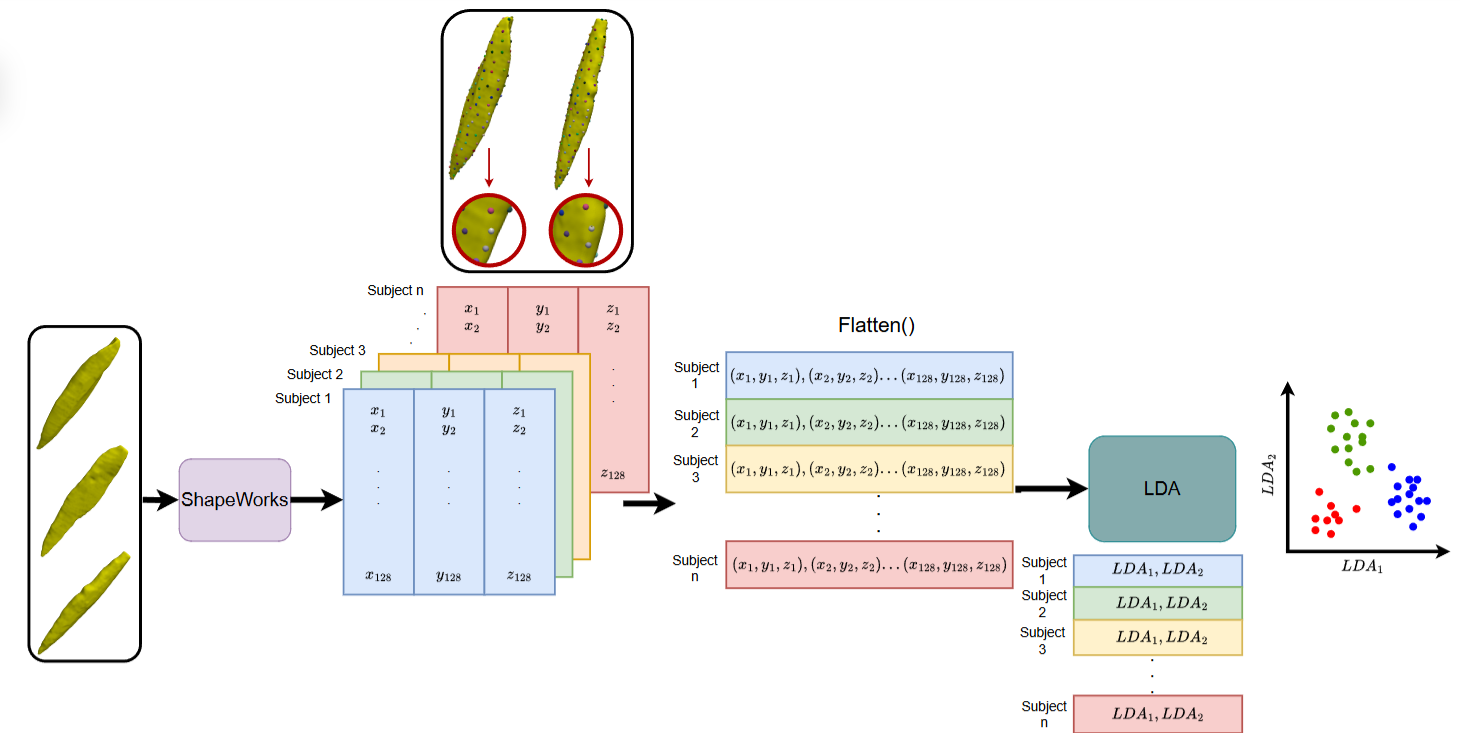

parts_flat_128 shape: 104 samples, 384 features
Fisher score multiclasse (généralisé) : 2.3031
Valeurs propres : [2.5296541  2.07662785]
Fisher score multiclasse (généralisé) exact : 2.3031
Fisher score (jeunes vs âgés) : 1.4495
Fisher score (âgés vs sarcopénique) : 1.6762
Fisher score (jeunes vs sarcopénique) : 1.9991


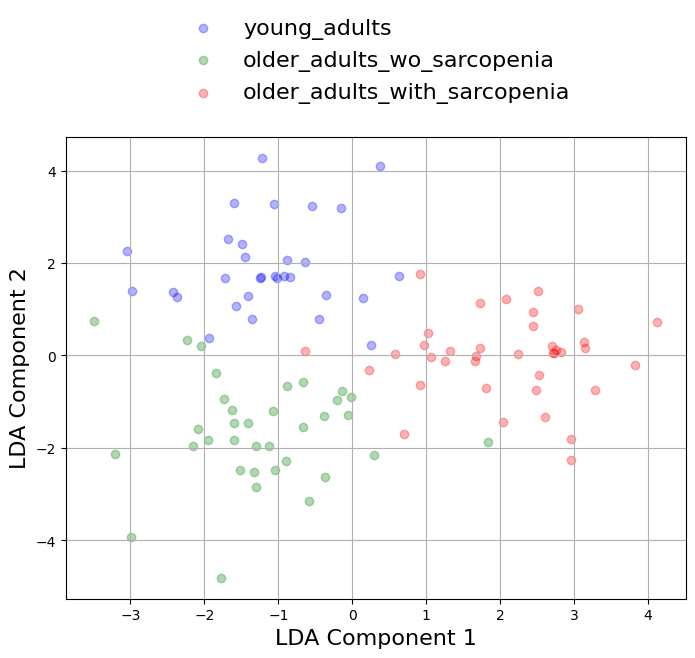

In [ ]:

# def compute_fisher_score(lda_projection_128, label_128):
#     # Calcule le score de Fisher pour la projection LDA
#     X = lda_projection_128  # projection LDA (n_samples, n_components)
#     y = label_128           # labels (n_samples,)

#     classes = np.unique(y)
#     n_classes = len(classes)
#     overall_mean = np.mean(X, axis=0)

#     # Matrices de dispersion inter-classes et intra-classes
#     S_B = np.zeros((X.shape[1], X.shape[1]))
#     S_W = np.zeros((X.shape[1], X.shape[1]))

#     for cls in classes:
#         X_c = X[y == cls]
#         mean_c = np.mean(X_c, axis=0)
#         n_c = X_c.shape[0]
    
#         # S_B: between-class scatter
#         mean_diff = (mean_c - overall_mean).reshape(-1, 1)
#         S_B += n_c * (mean_diff @ mean_diff.T)

#         # S_W: within-class scatter
#         cov_c = np.cov(X_c, rowvar=False)  # (d, d)
#         S_W += cov_c * (n_c - 1)

#     # Ratio de Fisher généralisé
#     fisher_score_multi = np.trace(S_B) / np.trace(S_W)

#     # Calcul des valeurs propres pour le score exact
#     eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
#     fisher_score_exact = np.mean(eigvals)
#     return fisher_score_exact

# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA : Répertoires pour le muscle TA (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL : Répertoires pour le muscle VL (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Sarcopenie_128"

# # Chargement des particules pour chaque groupe
# sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
# n, p, d = sarcopenie_parts_128.shape  # n: sujets, p: points, d: dimensions
# sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

# jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
# n, p, d = jeunes_parts_128.shape
# jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)

# vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
# n, p, d = vieu_parts_128.shape
# vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Fusionne les données des trois groupes pour LDA
parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128, sarcopenie_parts_flat_128))
label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128) + [2] * len(sarcopenie_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

# label_128 = np.random.randint(0, 3, size=len(label_128))  # Générer des étiquettes aléatoires entre 0 et 2


# Applique LDA directement sur les données (sans PCA)
lda_128 = LDA(n_components=2)
lda_projection_128 = lda_128.fit_transform(parts_flat_128, label_128)


# Calcul des matrices de dispersion inter-classes et intra-classes pour le score de Fisher
X = lda_projection_128  # projection LDA (n_samples, n_components)
y = label_128           # labels (n_samples,)

classes = np.unique(y)
n_classes = len(classes)
overall_mean = np.mean(X, axis=0)

# Initialisation des matrices de dispersion
S_B = np.zeros((X.shape[1], X.shape[1]))
S_W = np.zeros((X.shape[1], X.shape[1]))

for cls in classes:
    X_c = X[y == cls]
    mean_c = np.mean(X_c, axis=0)
    n_c = X_c.shape[0]
  
    # S_B: dispersion inter-classes
    mean_diff = (mean_c - overall_mean).reshape(-1, 1)
    S_B += n_c * (mean_diff @ mean_diff.T)

    # S_W: dispersion intra-classe
    cov_c = np.cov(X_c, rowvar=False)  # (d, d)
    S_W += cov_c * (n_c - 1)

# Calcul du score de Fisher généralisé
fisher_score_multi = np.trace(S_B) / np.trace(S_W)
print(f"Fisher score multiclasse (généralisé) : {fisher_score_multi:.4f}")

# Calcul des valeurs propres pour le score de Fisher exact
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
print(f"Valeurs propres : {eigvals}")
fisher_score_exact =  np.mean(eigvals) # ou max(eigvals) selon le critère
print(f"Fisher score multiclasse (généralisé) exact : {fisher_score_exact:.4f}")

# Calcul du ratio de Fisher pour chaque paire de clusters
# Liste des paires de classes à comparer
pairs = [(0, 1), (1, 2), (0, 2)]

label_names = {0: "jeunes", 1: "âgés", 2: "sarcopénique"}

for c1, c2 in pairs:
    # Sélectionner les indices correspondant aux deux classes
    idx = np.where((label_128 == c1) | (label_128 == c2))[0]
    lda_proj_pair = lda_projection_128[idx]
    label_pair = label_128[idx]
    # Calculer le score de Fisher pour cette paire
    fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
    print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")


# Visualisation de la projection LDA en 2D
plt.figure(figsize=(8, 6))
for label, label_str, color in zip([0, 1, 2], ['young_adults', 'older_adults_wo_sarcopenia', 'older_adults_with_sarcopenia'], ['blue', 'green', 'red']):
    plt.scatter(lda_projection_128[label_128 == label, 0], lda_projection_128[label_128 == label, 1], 
                c=color, label=f'{label_str}', alpha=0.3, marker='o')

# plt.title(f"LDA projection (without PCA)\nFisher Score: {fisher_score_exact:.2f}", fontsize=18, y=1.3)
plt.xlabel("LDA Component 1", fontsize=16)
plt.ylabel("LDA Component 2", fontsize=16)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=1, frameon=False, fontsize=16)
# Sauvegarder la figure en PDF
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Shape_Diffrence_RF_sans_titre_aleatoire.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Détection D'anomalies

La détection d’anomalies a pour objectif d’identifier des formes musculaires atypiques par rapport à la population de référence.  
Dans le cadre de l’étude des sujets sarcopéniques, cette approche est particulièrement pertinente car elle permet de :  

- repérer les déviations importantes par rapport à des formes considérées comme normales,  
- quantifier la sévérité des altérations morphologiques,  
- et explorer le potentiel du modèle statistique comme outil d’aide au diagnostic.  

Différentes méthodes ont été mises en œuvre pour évaluer les anomalies, notamment l’erreur de reconstruction, la validation LDA en train/test et une classification supervisée.  

## Séparation LDA train/test

Dans cette partie, un espace **PCA** est construit à partir des muscles sains afin de représenter la variabilité normale des formes.  
Ensuite, un groupe test composé de sujets normaux et sarcopéniques est projeté dans cet espace.  

Les projections issues à la fois du groupe d’entraînement (normal) et du groupe test sont ensuite transmises à une **LDA**, afin d’évaluer l’existence d’une séparation entre les deux populations.  

La figure ci-dessous illustre ce processus :  

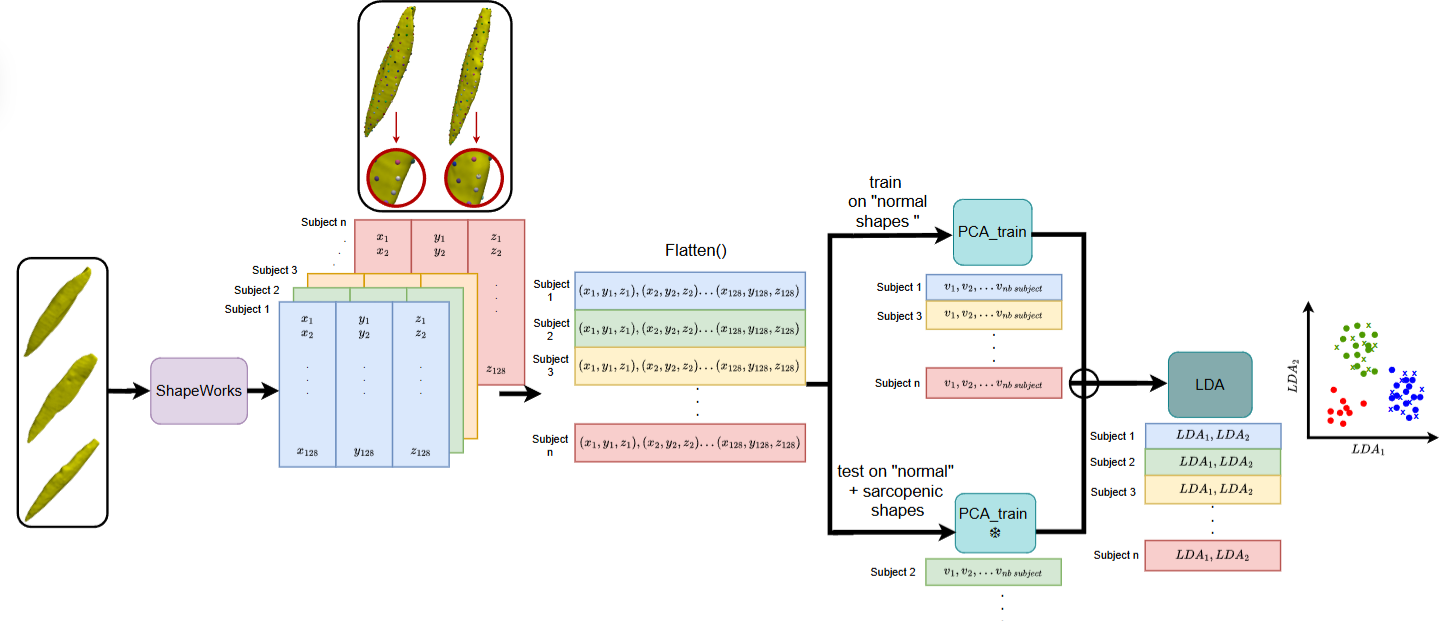

*Vue d’ensemble de la méthode de détection d’anomalies sur les points de correspondance utilisant le SSM.  
Les sujets du jeu de données (composés de jeunes adultes et d’adultes âgés sans sarcopénie) sont utilisés pour entraîner la PCA\_train.  
Une fois entraînée, la PCA\_train est appliquée aux formes « normales » ainsi qu’aux formes sarcopéniques.  
La LDA est ensuite appliquée sur cet espace de coefficients PCA afin de confirmer s’il existe des axes qui séparent bien les populations dans cet espace pour les sous-ensembles d’entraînement et de test.*  


parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64
Résultat MANOVA :
P-value globale Wilks' lambda : 3.681974950992172e-18
Fisher score (jeunes vs âgés) : 5.7933
Fisher score (âgés vs sarcopénique) : 1.0565
Fisher score (jeunes vs sarcopénique) : 6.3642


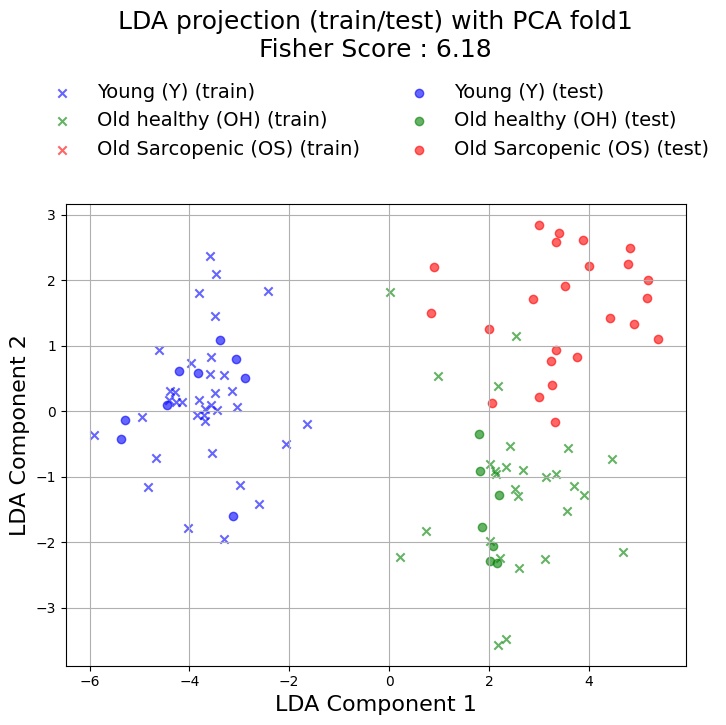

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64
Résultat MANOVA :
P-value globale Wilks' lambda : 3.3427983704576876e-19
Fisher score (jeunes vs âgés) : 4.4631
Fisher score (âgés vs sarcopénique) : 1.0434
Fisher score (jeunes vs sarcopénique) : 5.5267


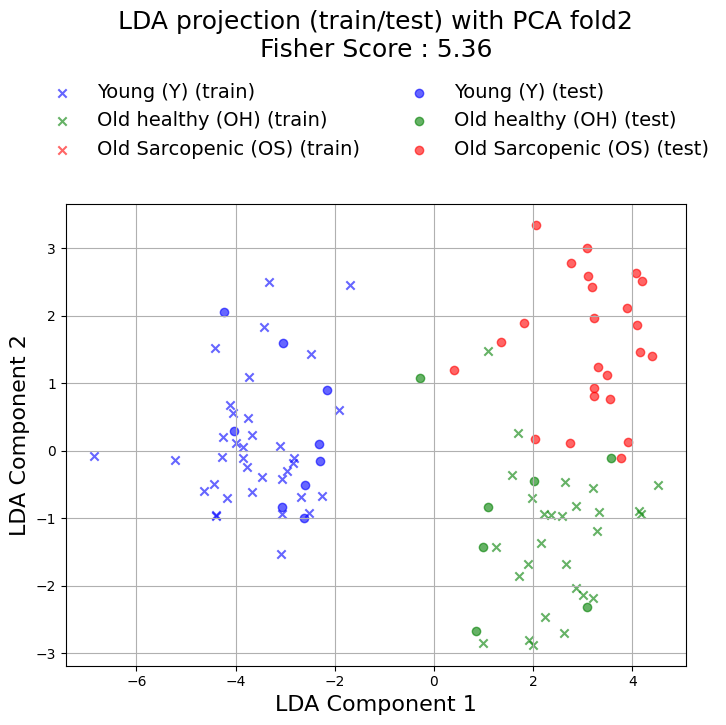

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64
Résultat MANOVA :
P-value globale Wilks' lambda : 2.151013166118174e-18
Fisher score (jeunes vs âgés) : 4.0892
Fisher score (âgés vs sarcopénique) : 1.0272
Fisher score (jeunes vs sarcopénique) : 4.9517


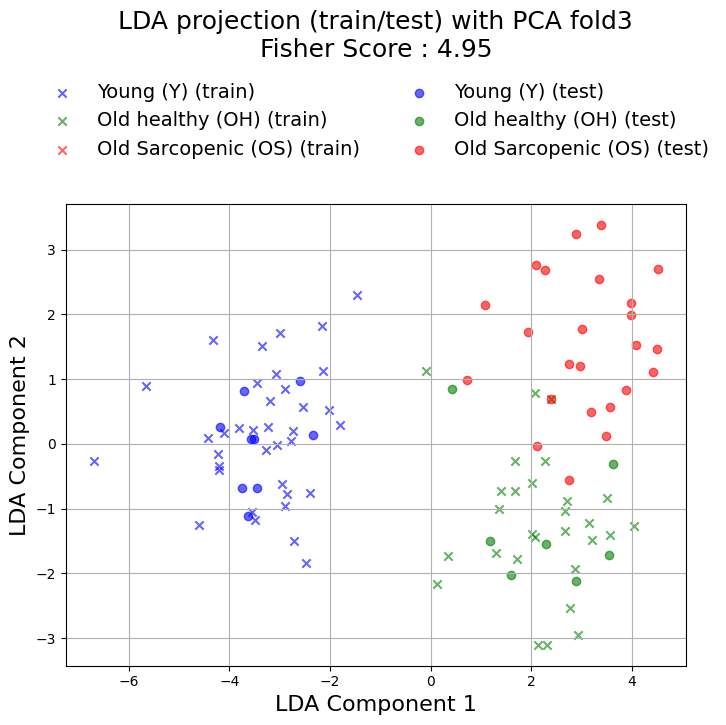

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64
Résultat MANOVA :
P-value globale Wilks' lambda : 3.545936129523805e-19
Fisher score (jeunes vs âgés) : 4.4151
Fisher score (âgés vs sarcopénique) : 1.1512
Fisher score (jeunes vs sarcopénique) : 5.5682


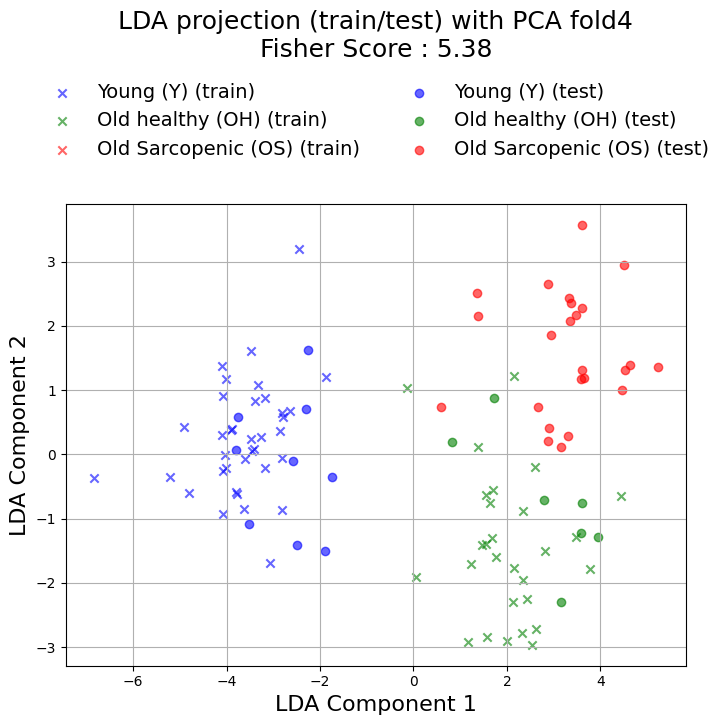

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64
Résultat MANOVA :
P-value globale Wilks' lambda : 1.1680316265210919e-17
Fisher score (jeunes vs âgés) : 5.4220
Fisher score (âgés vs sarcopénique) : 1.3832
Fisher score (jeunes vs sarcopénique) : 5.3538


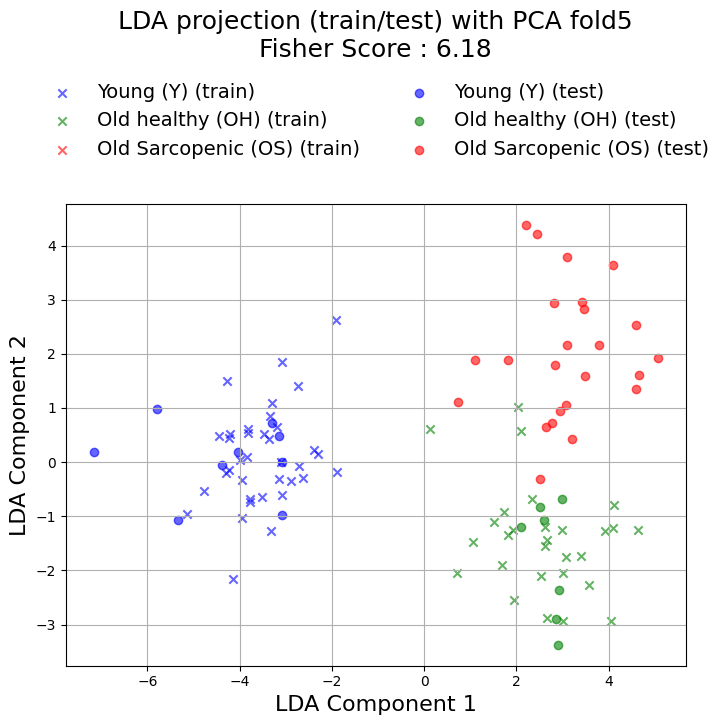

[6.175318947288757, 5.3604993943475785, 4.950651045690412, 5.378170539128215, 6.182107822137658]


In [48]:
def train_test_label(particules_train, particules_test):
    # Génère les labels pour les fichiers de particules d'entraînement et de test
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * 24))  # Ajoute 24 labels pour les particules de test sarcopénie
    return train_label, test_label

# def compute_fisher_score(lda_projection_128, label_128):
#     # Calcule le score de Fisher pour la projection LDA
#     X = lda_projection_128  # projection LDA (n_samples, n_components)
#     y = label_128           # labels (n_samples,)

#     classes = np.unique(y)
#     n_classes = len(classes)
#     overall_mean = np.mean(X, axis=0)

#     # Matrices de dispersion inter-classes et intra-classes
#     S_B = np.zeros((X.shape[1], X.shape[1]))
#     S_W = np.zeros((X.shape[1], X.shape[1]))

#     for cls in classes:
#         X_c = X[y == cls]
#         mean_c = np.mean(X_c, axis=0)
#         n_c = X_c.shape[0]
    
#         # S_B: between-class scatter
#         mean_diff = (mean_c - overall_mean).reshape(-1, 1)
#         S_B += n_c * (mean_diff @ mean_diff.T)

#         # S_W: within-class scatter
#         cov_c = np.cov(X_c, rowvar=False)  # (d, d)
#         S_W += cov_c * (n_c - 1)

#     # Ratio de Fisher généralisé
#     fisher_score_multi = np.trace(S_B) / np.trace(S_W)

#     # Calcul des valeurs propres pour le score exact
#     eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
#     fisher_score_exact = np.mean(eigvals)
#     return fisher_score_exact

# Définition des chemins des dossiers de particules pour différents groupes
# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
particles_dir_train_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train2",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train3",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train4",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train5"]
particles_dir_test_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test2",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test3",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test4",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test5"]

# TA : Répertoires pour le muscle TA (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
# particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/train"
# particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/test"

# VL : Répertoires pour le muscle VL (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Sarcopenie_128"
# particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/train"
# particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/test"

folds=1
list_fisher_score = []
list_fisher_old_sarco = []
for fold in range(len(particles_dir_train_list)):
    particles_dir_train = particles_dir_train_list[fold]
    particles_dir_test = particles_dir_test_list[fold]
    # Création des labels pour l'entraînement et le test
    train_label, test_label = train_test_label(particles_dir_train, particles_dir_test)

    # Chargement des particules sarcopénie et aplatissement
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    n, p, d = sarcopenie_parts_128.shape
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

    # Chargement des particules de test et aplatissement
    test_parts_128, test_names = get_particles(particles_dir_test, "world")
    n, p, d = test_parts_128.shape
    test_parts_flat_128 = test_parts_128.reshape(n, -1)

    # Chargement des particules d'entraînement et aplatissement
    train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
    n, p, d = train_parts_128.shape
    train_parts_flat_128 = train_parts_128.reshape(n, -1)

    # train_label = np.random.randint(0, 2, size=len(train_label))
    # test_label = np.random.randint(0, 3, size=len(test_label))  # Générer des étiquettes aléatoires entre 0 et 2


    # Ajout des particules sarcopénie au jeu de test
    test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

    print(f"parts_flat_128 shape (tain) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
    print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
    print(f"taille label_128 (train) : {len(train_label)}")
    print(f"taille label_128 (test) : {len(test_label)}")

    # Entraînement de la PCA sur les données d'entraînement
    max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
    scores_128 = []

    print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2)

    for n in component_range:
        # PCA sur les données d'entraînement
        pca_128 = PCA(n_components=n)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)

        # Concaténation des projections PCA train/test
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        # Projection LDA
        # LDA avec 2 composantes
        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

        # Calcul du score de Fisher
        score = compute_fisher_score(lda_projection_128, label_128)
        scores_128.append(score)

    # Recherche du nombre optimal de composantes PCA
    best_n_components_128 = component_range[np.argmax(scores_128)]
    best_score = max(scores_128)
    print(f"128 Particles ,Best Components : {best_n_components_128}")

    # PCA et LDA finales avec le meilleur nombre de composantes
    pca_128 = PCA(n_components=best_n_components_128)
    pca_train = pca_128.fit_transform(train_parts_flat_128)
    pca_test = pca_128.transform(test_parts_flat_128)
    pca_projection = np.concatenate((pca_train, pca_test))
    label_128 = np.concatenate((train_label, test_label))

    lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
    fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
    # Séparation des projections LDA pour train et test
    lda_train = lda_projection_128[:len(train_label), :]
    lda_test = lda_projection_128[len(train_label):, :]

    import pandas as pd
    from statsmodels.multivariate.manova import MANOVA
    # On suppose que lda_projection_128 contient les 2 axes LDA
    z_lda = pca_projection  # shape (n_samples, 2)
    y = label_128  # labels des classes

    # z_lda = lda_projection_128  # shape (n_samples, 2)
    # y = label_128  # labels des classes

    # Création d'un DataFrame pour MANOVA
    df_anova = pd.DataFrame({
        "LDA1": z_lda[:, 0],
        "LDA2": z_lda[:, 1],
        "Group": y
    })

    # MANOVA multivariée : test global des deux axes simultanément
    maov = MANOVA.from_formula('LDA1 + LDA2 ~ Group', data=df_anova)
    manova_res = maov.mv_test()

    # P-value globale (Wilks' lambda)
    p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

    print("Résultat MANOVA :")
    # print(manova_res)
    print(f"P-value globale Wilks' lambda : {p_value}")



    # Calcul du ratio de Fisher pour chaque paire de clusters
    # Liste des paires de classes à comparer
    pairs = [(0, 1), (1, 2), (0, 2)]

    label_names = {0: "jeunes", 1: "âgés", 2: "sarcopénique"}
    fisher_score_tab = []
    for c1, c2 in pairs:
        # Sélectionner les indices correspondant aux deux classes
        idx = np.where((label_128 == c1) | (label_128 == c2))[0]
        lda_proj_pair = lda_projection_128[idx]
        label_pair = label_128[idx]
        # Calculer le score de Fisher pour cette paire
        fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
        print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
        fisher_score_tab.append(fisher_score)
        # print(fisher_score)

    list_fisher_old_sarco.append(fisher_score_tab)
    # Visualisation des résultats LDA en 2D
    plt.figure(figsize=(8, 6))

    # Données d'entraînement
    for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
        plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
                    c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

    # Données de test
    for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
        plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
                    c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

    plt.title(f"LDA projection (train/test) with PCA fold{folds}\nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
    plt.xlabel("LDA Component 1", fontsize=16)
    plt.ylabel("LDA Component 2", fontsize=16)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
    plt.grid(True)
    plt.savefig(f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_RF_{folds}.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    list_fisher_score.append(fisher_score_exact)
    folds+=1

print(list_fisher_score)

# # Transformation directe en array numpy
# scores_array = np.array(list_fisher_old_sarco)  # shape: (3 groupes, 3 variables, n_échantillons)
# print(scores_array.shape)
# # Réorganisation des données
# n_groups, n_variables, n_samples = scores_array.shape
# data = {
#     'Score1': scores_array[:, 0, :].flatten(),
#     'Score2': scores_array[:, 1, :].flatten(), 
#     'Score3': scores_array[:, 2, :].flatten(),
#     'Group': np.repeat(['Dist1', 'Dist2', 'Dist3'], n_samples)
# }

# df_manova = pd.DataFrame(data)

# # MANOVA
# maov = MANOVA.from_formula('Score1 + Score2 + Score3 ~ Group', data=df_manova)
# manova_res = maov.mv_test()
# p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

# print("Résultat MANOVA :")
# print(manova_res)
# print(f"\nP-value globale Wilks' lambda : {p_value:.6f}")

### Influence des axes PCA sur la séparation LDA  

L’analyse de l’influence de chaque axe de la **PCA** sur la séparation obtenue par la **LDA** permet de mieux comprendre quelles variations de forme sont les plus discriminantes entre les groupes.  

En effet :  
- La **PCA** capture les principales directions de variabilité des formes musculaires, sans tenir compte des classes.  
- La **LDA** cherche ensuite à projeter ces données dans un espace où la séparation entre groupes (normaux et sarcopéniques) est maximisée.  

Étudier l’impact de chaque axe PCA sur la LDA revient donc à identifier **quelles variations anatomiques contribuent le plus à la discrimination entre les populations**.  
Cela apporte une meilleure interprétation biologique du modèle, en reliant directement certaines dimensions de variabilité de forme aux différences cliniques observées.  


Composante PCA 64 : importance 32.26%
Composante PCA 48 : importance 5.23%
Composante PCA 52 : importance 4.16%
Composante PCA 61 : importance 3.53%
Composante PCA 62 : importance 3.50%
Composante PCA 46 : importance 3.36%
Composante PCA 49 : importance 3.08%
Composante PCA 34 : importance 3.04%
Composante PCA 37 : importance 2.39%
Composante PCA 63 : importance 2.05%
Composante PCA 60 : importance 1.97%
Composante PCA 58 : importance 1.77%
Composante PCA 39 : importance 1.76%
Composante PCA 54 : importance 1.70%
Composante PCA 53 : importance 1.69%
Composante PCA 31 : importance 1.50%
Composante PCA 44 : importance 1.49%
Composante PCA 50 : importance 1.41%
Composante PCA 33 : importance 1.41%
Composante PCA 38 : importance 1.24%
Composante PCA 59 : importance 1.21%
Composante PCA 51 : importance 1.20%
Composante PCA 28 : importance 1.09%
Composante PCA 55 : importance 1.03%
Composante PCA 40 : importance 1.02%
Composante PCA 16 : importance 1.00%
Composante PCA 56 : importance 0.93%


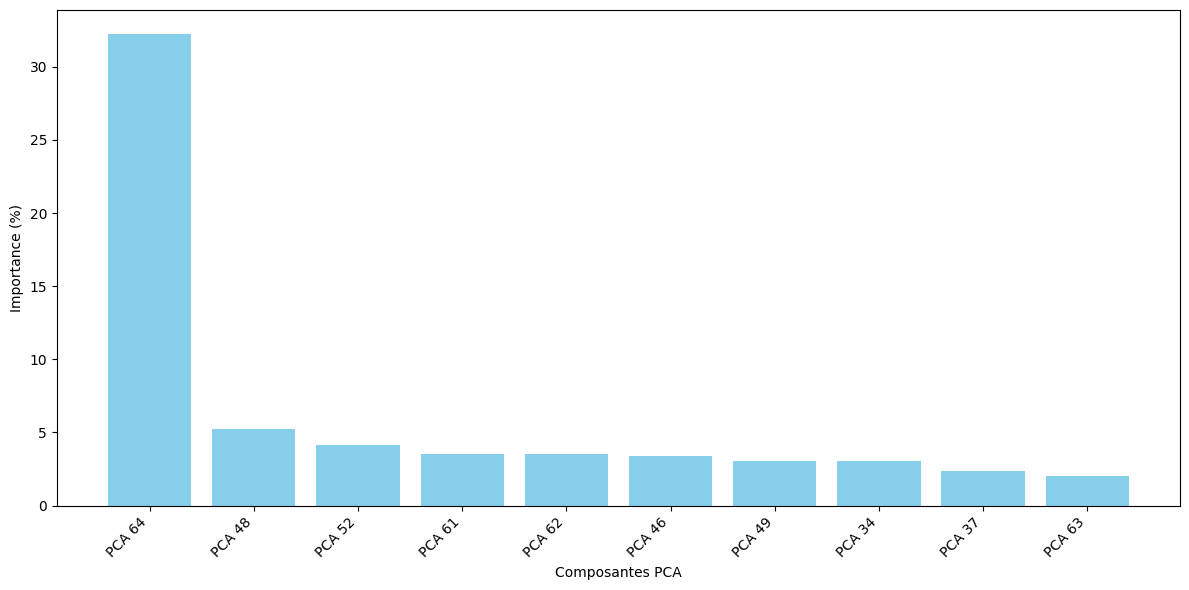

In [ ]:
# Poids de la direction LDA dans l'espace PCA
lda_weights = lda_128.coef_[0]

# Importance relative des composantes PCA
importance = np.abs(lda_weights) / np.sum(np.abs(lda_weights))

# Affichage trié
sorted_importance = sorted(enumerate(importance), key=lambda x: -x[1])
# Affichage trié
for i, imp in sorted(enumerate(importance), key=lambda x: -x[1]):
    print(f"Composante PCA {i+1} : importance {imp:.2%}")
print(f"somme des importances : {np.sum(importance):.2%}")

# Affichage des composantes importantes sous forme d'histogramme
components = [f"PCA {i+1}" for i, _ in sorted_importance]
values = [imp*100 for _, imp in sorted_importance]

plt.figure(figsize=(12, 6))
plt.bar(components[:10], values[:10], color='skyblue')  # Afficher les 20 premières composantes
plt.xticks(rotation=45, ha='right')
plt.xlabel("Composantes PCA")
plt.ylabel("Importance (%)")
# plt.title("Importance des composantes PCA (Top 20)")
plt.tight_layout()
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_Importance_RF.pdf", format='pdf', bbox_inches='tight')

plt.show()

### P-Value sur PCA

_RF
sarcopenie_parts_128 shape : ['Malades_AL135_RF_world', 'Malades_AM112_RF_label_world', 'Malades_BA137_RF_label_world', 'Malades_BM103_RF_label_world', 'Malades_CY164_RF_seg_world', 'Malades_DI154_RF_label_world', 'Malades_DP172_RF_label_world', 'Malades_DR160_RF_label_world', 'Malades_EM151_RF_label_world', 'Malades_EP105_RF_label_world', 'Malades_FO117_RF_label_world', 'Malades_GD171_RF_label_world', 'Malades_LA134_RF_label_world', 'Malades_LA162_RF_label_world', 'Malades_LJ139_RF_label_world', 'Malades_LP133_RF_label_world', 'Malades_MA119_RF_label_world', 'Malades_MM170_RF_label_world', 'Malades_PG161_RF_label_world', 'Malades_PP104_RF_label_world', 'Malades_QP108_RF_label_world', 'Malades_RA150_RF_label_world', 'Malades_RJ136_RF_label_world', 'Malades_SC146_RF_label_world']
particles_dir_train : ['Jeunes_sujet10_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet10_RF_fort_3DUS_label_world.particles', 'Jeunes_sujet10_RF_pad_3DUS_label_world.particles', 'Jeunes_sujet11_RF_faib

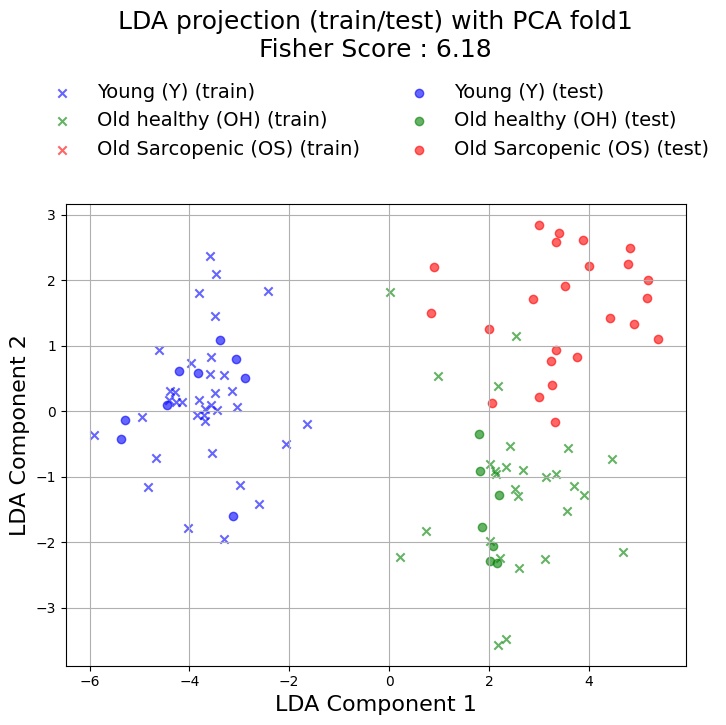

[6.175318947288757]
_TA
sarcopenie_parts_128 shape : ['Malades_AL135_TA_seg_world', 'Malades_AM112_TA_seg_world', 'Malades_BA137_TA_seg_world', 'Malades_BM103_TA_seg_world', 'Malades_DI154_TA_seg_world', 'Malades_DR160_TA_seg_world', 'Malades_EM151_TA_seg_world', 'Malades_EP105_TA_seg_world', 'Malades_FO117_TA_seg_world', 'Malades_GD171_TA_seg_world', 'Malades_LA134_TA_seg_world', 'Malades_LA162_TA_seg_world', 'Malades_LJ139_TA_seg_world', 'Malades_LP133_TA_seg_world', 'Malades_MA119_TA_seg_world', 'Malades_MM170_TA_seg_world', 'Malades_PG161_TA_seg_world', 'Malades_PP104_TA_seg_world', 'Malades_QP108_TA_seg_world', 'Malades_RA150_TA_seg_world', 'Malades_RJ136_TA_seg_world', 'Malades_SC146_TA_seg_world']
particles_dir_train : ['Jeunes_sujet10_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet10_RF_fort_3DUS_label_world.particles', 'Jeunes_sujet10_RF_pad_3DUS_label_world.particles', 'Jeunes_sujet11_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet11_RF_fort_3DUS_label_world.particl

ValueError: Found input variables with inconsistent numbers of samples: [102, 69]

In [41]:
def train_test_label(particules_dir_train, particules_dir_test, jeunes_names, vieu_names, sarcopenie_names, sufix):
    # Génère les labels pour les fichiers de particules d'entraînement et de test
    print(f"particles_dir_train : {os.listdir(particles_dir_train)} ")
    print(f"jeunes dir : {jeunes_names} ")
    # particles_train = [name for name in os.listdir(particles_dir_train) if name in jeunes_names or name in vieu_names]
    dir_train = os.listdir(particles_dir_train)
    dir_test = os.listdir(particles_dir_test)

    def normalize_name(name: str) -> str:
        # Enlever l'extension
        base = os.path.splitext(name)[0]
        # Remplacer _RF par suffix
        base = base.replace('_RF', sufix)
        # Garder uniquement les 4 premiers segments
        parts = base.split('_')
        return '_'.join(parts[:4])
    
    jeunes_names = ['_'.join(name.split('_')[:4]) for name in jeunes_names]
    vieu_names = ['_'.join(name.split('_')[:4]) for name in vieu_names]
    sarcopenie_names = ['_'.join(name.split('_')[:4]) for name in sarcopenie_names]

    particles_train = [
        os.path.splitext(name)[0].replace('_RF', sufix)
        for name in os.listdir(particles_dir_train)
        if normalize_name(name) in jeunes_names or normalize_name(name) in vieu_names
    ]
    print(f"particles_dir_train : {particles_train} ")

    particles_test = [
        normalize_name(name)
        for name in os.listdir(particles_dir_test)
        if normalize_name(name) in jeunes_names
        or normalize_name(name) in vieu_names
        or normalize_name(name) in sarcopenie_names
    ]
    # particles_test = [name for name in particles_dir_test if name in jeunes_names or name in vieu_names or name in sarcopenie_names]
    

    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in particles_train]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in particles_test]
    try :
        test_label = np.concatenate((test_label, [2] * 24))  # Ajoute 24 labels pour les particules de test sarcopénie
    except:
        test_label = np.concatenate((test_label, [2] * 22))  # Ajoute 12 labels pour les particules de test sarcopénie
    print(len(train_label))    
    print(len(test_label))
    return train_label, test_label

# def compute_fisher_score(lda_projection_128, label_128):
#     # Calcule le score de Fisher pour la projection LDA
#     X = lda_projection_128  # projection LDA (n_samples, n_components)
#     y = label_128           # labels (n_samples,)

#     classes = np.unique(y)
#     n_classes = len(classes)
#     overall_mean = np.mean(X, axis=0)

#     # Matrices de dispersion inter-classes et intra-classes
#     S_B = np.zeros((X.shape[1], X.shape[1]))
#     S_W = np.zeros((X.shape[1], X.shape[1]))

#     for cls in classes:
#         X_c = X[y == cls]
#         mean_c = np.mean(X_c, axis=0)
#         n_c = X_c.shape[0]
    
#         # S_B: between-class scatter
#         mean_diff = (mean_c - overall_mean).reshape(-1, 1)
#         S_B += n_c * (mean_diff @ mean_diff.T)

#         # S_W: within-class scatter
#         cov_c = np.cov(X_c, rowvar=False)  # (d, d)
#         S_W += cov_c * (n_c - 1)

#     # Ratio de Fisher généralisé
#     fisher_score_multi = np.trace(S_B) / np.trace(S_W)

#     # Calcul des valeurs propres pour le score exact
#     eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
#     fisher_score_exact = np.mean(eigvals)
#     return fisher_score_exact

# Définition des chemins des dossiers de particules pour différents groupes
# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
particles_dir_train_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train2",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train3",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train4"]
particles_dir_test_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test2",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test3",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test4"]

# Chemins des données (adapter selon le muscle voulu)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
}



# # Récupération des erreurs pour chaque muscle
# errors_train_tot_RF = errors_dict_RF["errors_train"]
# errors_test_tot_RF = errors_dict_RF["errors_test"]
# errors_sarcopenie_tot_RF = errors_dict_RF["errors_sarcopenie"]

# errors_train_tot_TA = errors_dict_TA["errors_train"]
# errors_test_tot_TA = errors_dict_TA["errors_test"]
# errors_sarcopenie_tot_TA = errors_dict_TA["errors_sarcopenie"]

# errors_train_tot_VL = errors_dict_VL["errors_train"]
# errors_test_tot_VL = errors_dict_VL["errors_test"]
# errors_sarcopenie_tot_VL = errors_dict_VL["errors_sarcopenie"]

# # Vérification des shapes pour s'assurer que tout est correct
# print("Train RF shape:", np.array(errors_train_tot_RF).shape)
# print("Test RF shape:", np.array(errors_test_tot_RF).shape)
# print("Sarcopenie RF shape:", np.array(errors_sarcopenie_tot_RF).shape)



def compute_LDA(particles_dir_sarcopenie_128, particles_dir_jeunes_128, particles_dir_vieu_128, particles_dir_train_list, particles_dir_test_list, n_components, sufix):
    print(sufix)

    folds=1
    list_fisher_score = []
    list_fisher_old_sarco = []
    for fold in range(1):#len(particles_dir_train_list)):
        particles_dir_train = particles_dir_train_list[fold]
        particles_dir_test = particles_dir_test_list[fold]
        

        # Chargement des particules sarcopénie et aplatissement
        sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
        print(f"sarcopenie_parts_128 shape : {sarcopenie_names}")
        n, p, d = sarcopenie_parts_128.shape
        sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

        # Chargement des particules de test et aplatissement
        test_parts_128, test_names = get_particles(particles_dir_test, "world")
        n, p, d = test_parts_128.shape
        test_parts_flat_128 = test_parts_128.reshape(n, -1)

        # Chargement des particules d'entraînement et aplatissement
        train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
        n, p, d = train_parts_128.shape
        train_parts_flat_128 = train_parts_128.reshape(n, -1)

        # train_label = np.random.randint(0, 2, size=len(train_label))
        # test_label = np.random.randint(0, 3, size=len(test_label))  # Générer des étiquettes aléatoires entre 0 et 2
        
        jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
        vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")

        # Ajout des particules sarcopénie au jeu de test
        test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

        
        # Création des labels pour l'entraînement et le test
        train_label, test_label = train_test_label(particles_dir_train, particles_dir_test, jeunes_names, vieu_names, sarcopenie_names, sufix)

        print(f"parts_flat_128 shape (tain) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
        print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
        print(f"taille label_128 (train) : {len(train_label)}")
        print(f"taille label_128 (test) : {len(test_label)}")

        # Entraînement de la PCA sur les données d'entraînement
        max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
        scores_128 = []

        print(f"Training PCA with {max_components} components")
        component_range = range(2, max_components + 1, 2)

        for n in component_range:
            # PCA sur les données d'entraînement
            pca_128 = PCA(n_components=n)
            pca_train = pca_128.fit_transform(train_parts_flat_128)
            pca_test = pca_128.transform(test_parts_flat_128)

            # Concaténation des projections PCA train/test
            pca_projection = np.concatenate((pca_train, pca_test))
            print(f"projection pca shape : {pca_projection.shape}")
            label_128 = np.concatenate((train_label, test_label))
            print(f"label_128 shape : {label_128.shape}")

            # Projection LDA
            # LDA avec 2 composantes
            lda_128 = LDA(n_components=2)
            lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

            # Calcul du score de Fisher
            score = compute_fisher_score(lda_projection_128, label_128)
            scores_128.append(score)

        # Recherche du nombre optimal de composantes PCA
        best_n_components_128 = component_range[np.argmax(scores_128)]
        best_score = max(scores_128)
        print(f"128 Particles ,Best Components : {best_n_components_128}")

        # PCA et LDA finales avec le meilleur nombre de composantes
        pca_128 = PCA(n_components=best_n_components_128)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
        fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
        # Séparation des projections LDA pour train et test
        lda_train = lda_projection_128[:len(train_label), :]
        lda_test = lda_projection_128[len(train_label):, :]

        
        # Calcul du ratio de Fisher pour chaque paire de clusters
        # Liste des paires de classes à comparer
        pairs = [(0, 1), (1, 2), (0, 2)]

        label_names = {0: "jeunes", 1: "âgés", 2: "sarcopénique"}
        fisher_score_tab = []
        for c1, c2 in pairs:
            # Sélectionner les indices correspondant aux deux classes
            idx = np.where((label_128 == c1) | (label_128 == c2))[0]
            lda_proj_pair = lda_projection_128[idx]
            label_pair = label_128[idx]
            # Calculer le score de Fisher pour cette paire
            fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
            print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
            fisher_score_tab.append(fisher_score)
            # print(fisher_score)

        list_fisher_old_sarco.append(fisher_score_tab)
        # Visualisation des résultats LDA en 2D
        plt.figure(figsize=(8, 6))

        # Données d'entraînement
        for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
            plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
                        c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

        # Données de test
        for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
            plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
                        c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

        plt.title(f"LDA projection (train/test) with PCA fold{folds}\nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
        plt.xlabel("LDA Component 1", fontsize=16)
        plt.ylabel("LDA Component 2", fontsize=16)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
        plt.grid(True)
        plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_VL_sans_titre.pdf", format='pdf', bbox_inches='tight')
        plt.show()
        list_fisher_score.append(fisher_score_exact)
        folds+=1

    print(list_fisher_score)

# Appel de la fonction
errors_dict_RF = compute_LDA(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    particles_dir_train_list, 
    particles_dir_test_list,
    n_components=6,
    sufix="_RF"
)

errors_dict_TA = compute_LDA(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    particles_dir_train_list, 
    particles_dir_test_list,
    n_components=6,
    sufix="_TA"
)

errors_dict_VL = compute_LDA(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    particles_dir_train_list, 
    particles_dir_test_list,
    n_components=6,
    sufix="_VL"
)


RF
sarcopenie_parts_128 shape : ['Malades_AL135_RF_world', 'Malades_AM112_RF_label_world', 'Malades_BA137_RF_label_world', 'Malades_BM103_RF_label_world', 'Malades_CY164_RF_seg_world', 'Malades_DI154_RF_label_world', 'Malades_DP172_RF_label_world', 'Malades_DR160_RF_label_world', 'Malades_EM151_RF_label_world', 'Malades_EP105_RF_label_world', 'Malades_FO117_RF_label_world', 'Malades_GD171_RF_label_world', 'Malades_LA134_RF_label_world', 'Malades_LA162_RF_label_world', 'Malades_LJ139_RF_label_world', 'Malades_LP133_RF_label_world', 'Malades_MA119_RF_label_world', 'Malades_MM170_RF_label_world', 'Malades_PG161_RF_label_world', 'Malades_PP104_RF_label_world', 'Malades_QP108_RF_label_world', 'Malades_RA150_RF_label_world', 'Malades_RJ136_RF_label_world', 'Malades_SC146_RF_label_world']
parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Pa

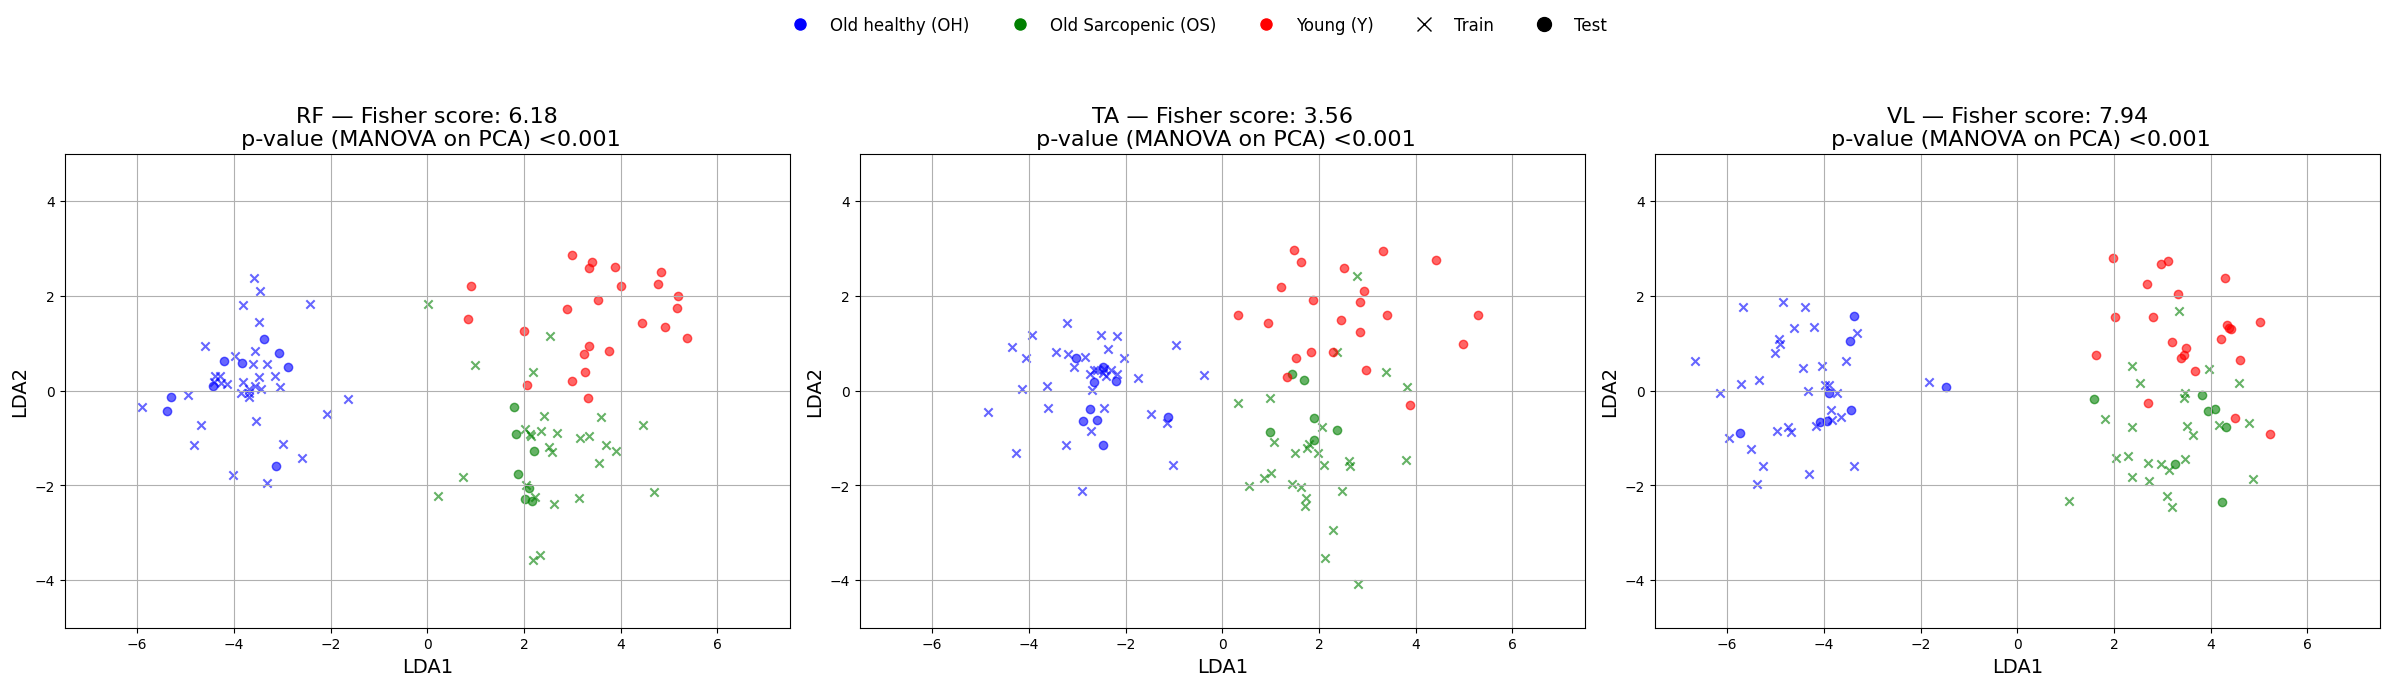

In [36]:
# Chemins des données (adapter selon le muscle voulu)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/test"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/test"
}

def train_test_label(particules_train, particules_test, nb_sarco):
    # Génère les labels pour les fichiers de particules d'entraînement et de test
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * nb_sarco))  # Ajoute 24 labels pour les particules de test sarcopénie
    
    return train_label, test_label



def compute_LDA(particles_dir_sarcopenie_128, particles_dir_jeunes_128, particles_dir_vieu_128, particles_dir_train, particles_dir_test, n_components, sufix, nb_sarco):
    print(sufix)

    folds=1
    list_fisher_score = []
    list_fisher_old_sarco = []
    

    # Chargement des particules sarcopénie et aplatissement
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    print(f"sarcopenie_parts_128 shape : {sarcopenie_names}")
    n, p, d = sarcopenie_parts_128.shape
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

    # Chargement des particules de test et aplatissement
    test_parts_128, test_names = get_particles(particles_dir_test, "world")
    n, p, d = test_parts_128.shape
    test_parts_flat_128 = test_parts_128.reshape(n, -1)

    # Chargement des particules d'entraînement et aplatissement
    train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
    n, p, d = train_parts_128.shape
    train_parts_flat_128 = train_parts_128.reshape(n, -1)

    # train_label = np.random.randint(0, 2, size=len(train_label))
    # test_label = np.random.randint(0, 3, size=len(test_label))  # Générer des étiquettes aléatoires entre 0 et 2
    
    jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
    vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")

    # Ajout des particules sarcopénie au jeu de test
    test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

    
    # Création des labels pour l'entraînement et le test
    train_label, test_label = train_test_label(particles_dir_train, particles_dir_test,nb_sarco)

    if test_label.shape[0] != test_parts_flat_128.shape[0]:
        test_label = test_label[:test_parts_flat_128.shape[0]]

    print(f"parts_flat_128 shape (tain) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
    print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
    print(f"taille label_128 (train) : {len(train_label)}")
    print(f"taille label_128 (test) : {len(test_label)}")

    # Entraînement de la PCA sur les données d'entraînement
    max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
    scores_128 = []
    print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2)

    for n in component_range:
        # PCA sur les données d'entraînement
        pca_128 = PCA(n_components=n)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)

        # Concaténation des projections PCA train/test
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        # Projection LDA
        # LDA avec 2 composantes
        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

        # Calcul du score de Fisher
        score = compute_fisher_score(lda_projection_128, label_128)
        scores_128.append(score)

    # Recherche du nombre optimal de composantes PCA
    best_n_components_128 = component_range[np.argmax(scores_128)]
    best_score = max(scores_128)
    print(f"128 Particles ,Best Components : {best_n_components_128}")

    # PCA et LDA finales avec le meilleur nombre de composantes
    pca_128 = PCA(n_components=best_n_components_128)
    pca_train = pca_128.fit_transform(train_parts_flat_128)
    pca_test = pca_128.transform(test_parts_flat_128)
    pca_projection = np.concatenate((pca_train, pca_test))
    label_128 = np.concatenate((train_label, test_label))

    lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
    fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
    # Séparation des projections LDA pour train et test
    lda_train = lda_projection_128[:len(train_label), :]
    lda_test = lda_projection_128[len(train_label):, :]

    
    # Calcul du ratio de Fisher pour chaque paire de clusters
    # Liste des paires de classes à comparer
    pairs = [(0, 1), (1, 2), (0, 2)]

    label_names = {0: "jeunes", 1: "âgés", 2: "sarcopénique"}
    fisher_score_tab = []
    for c1, c2 in pairs:
        # Sélectionner les indices correspondant aux deux classes
        idx = np.where((label_128 == c1) | (label_128 == c2))[0]
        lda_proj_pair = lda_projection_128[idx]
        label_pair = label_128[idx]
        # Calculer le score de Fisher pour cette paire
        fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
        print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
        fisher_score_tab.append(fisher_score)
        # print(fisher_score)

    list_fisher_old_sarco.append(fisher_score_tab)
    # Visualisation des résultats LDA en 2D
    # plt.figure(figsize=(8, 6))

    # # Données d'entraînement
    # for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
    #     plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
    #                 c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

    # # Données de test
    # for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
    #     plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
    #                 c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

    # plt.title(f"LDA projection (train/test) with PCA \nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
    # plt.xlabel("LDA Component 1", fontsize=16)
    # plt.ylabel("LDA Component 2", fontsize=16)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
    # plt.grid(True)
    # plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_VL_sans_titre.pdf", format='pdf', bbox_inches='tight')
    # plt.show()
    list_fisher_score.append(fisher_score_exact)
    folds+=1

    print(list_fisher_score)

    return {
        "sufix": sufix,
        "lda_train": lda_train,
        "lda_test": lda_test,
        "train_label": train_label,
        "test_label": test_label,
        "pca_train": pca_train,
        "pca_test": pca_test,
        "pca_projection": pca_projection,
        "label": label_128,
        "fisher_score_exact": fisher_score_exact,
    }

# Appel de la fonction
LDA_dict_RF = compute_LDA(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    particles_dir_RF["train"], 
    particles_dir_RF["test"],
    n_components=6,
    sufix="RF",
    nb_sarco=24
)

LDA_dict_TA = compute_LDA(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    particles_dir_TA["train"], 
    particles_dir_TA["test"],
    n_components=6,
    sufix="TA",
    nb_sarco=22
)

LDA_dict_VL = compute_LDA(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    particles_dir_VL["train"], 
    particles_dir_VL["test"],
    n_components=6,
    sufix="VL",
    nb_sarco=23
)



import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import numpy as np
def calculate_manova(LDA_dict):
    
    # Construire DataFrame PCA
    pca_train_df = pd.DataFrame(LDA_dict['pca_projection'], columns=[f'PC{i+1}' for i in range(LDA_dict['pca_projection'].shape[1])])
    pca_train_df['Group'] = LDA_dict['label']

    # Vérifier nombre de samples par groupe
    group_counts = pca_train_df['Group'].value_counts()
    min_group_size = group_counts.min()
    print("Nombre de samples par groupe :", group_counts)

    # Limiter le nombre de colonnes PCA pour MANOVA
    max_cols = min(min_group_size - 1, LDA_dict['pca_projection'].shape[1])  # MANOVA exige n_samples > n_variables
    if max_cols < 1:
        print("Pas assez d'échantillons pour MANOVA")
        p_value = np.nan
    else:
        pca_cols = [f'PC{i+1}' for i in range(max_cols)]
        formula = " + ".join(pca_cols) + " ~ Group"

        try:
            maov = MANOVA.from_formula(formula, data=pca_train_df)
            manova_res = maov.mv_test()
            p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

        except Exception as e:
            print("Erreur MANOVA :", e)
            p_value = np.nan

    print("p-value MANOVA :", p_value)
    return "<0.001" if p_value < 0.001 else p_value




import matplotlib.pyplot as plt
import numpy as np


# Classes et couleurs
labels = [0, 1, 2]
label_names = ['Old healthy (OH)','Old Sarcopenic (OS)', 'Young (Y)', ]
colors = ['blue', 'green', 'red']


# Créer 3 graphes LDA côte à côte
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Fonction d'affichage LDA (réutilisable)
def plot_lda(ax, lda_train, lda_test, train_label, test_label, title):
    for label, label_str, color in zip(labels, label_names, colors):
        ax.scatter(
            lda_train[np.array(train_label) == label, 0],
            lda_train[np.array(train_label) == label, 1],
            c=color, alpha=0.6, marker='x', label=f'{label_str} (train)'
        )
        ax.scatter(
            lda_test[np.array(test_label) == label, 0],
            lda_test[np.array(test_label) == label, 1],
            c=color, alpha=0.6, marker='o', label=f'{label_str} (test)'
        )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("LDA1", fontsize=14)
    ax.set_ylabel("LDA2", fontsize=14)
    # Limites manuelles
    x_lim = (-7.5, 7.5)
    y_lim = (-5, 5)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid(True)

# Tracer les 3 graphes
plot_lda(axes[0], LDA_dict_RF["lda_train"], LDA_dict_RF["lda_test"], LDA_dict_RF["train_label"], LDA_dict_RF["test_label"], f"{LDA_dict_RF['sufix']} — Fisher score: {LDA_dict_RF['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_RF)}")
plot_lda(axes[1], LDA_dict_TA["lda_train"], LDA_dict_TA["lda_test"], LDA_dict_TA["train_label"], LDA_dict_TA["test_label"], f"{LDA_dict_TA['sufix']} — Fisher score: {LDA_dict_TA['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_TA)}")
plot_lda(axes[2], LDA_dict_VL["lda_train"], LDA_dict_VL["lda_test"], LDA_dict_VL["train_label"], LDA_dict_VL["test_label"], f"{LDA_dict_VL['sufix']} — Fisher score: {LDA_dict_VL['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_VL)}")
from matplotlib.lines import Line2D

# Légende personnalisée
class_handles = [Line2D([0], [0], marker='o', color='w', label=lbl, markerfacecolor=col, markersize=10) 
                 for lbl, col in zip(label_names, colors)]
type_handles = [
    Line2D([0], [0], marker='x', color='black', label='Train', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='black', label='Test', markersize=10, linestyle='None')
]

fig.legend(
    handles=class_handles + type_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # x=0.5 centre, y=1.15 au-dessus de la figure
    ncol=5,
    frameon=False,
    fontsize=12
)
# Titre global
# fig.suptitle(f"{['sufix']} — Fisher score: {LDA_dict_RF['fisher_score_exact']:.2f}", fontsize=20, y=1.05)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/lda_scatter_plots_multy_muscles_SSM.pdf", format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()




## Erreur de Reconstruction


Une PCA est entraînée uniquement à partir des muscles du groupe sain (jeunes et âgés sans sarcopénie) afin de construire un espace de forme représentatif des variations normales.  
Les formes des sujets (normaux et sarcopéniques) sont ensuite projetées dans cet espace, puis reconstruites.  

L’**erreur de reconstruction** correspond à la différence moyenne entre les points de correspondance réels et ceux reconstruits.  
Elle permet de mesurer dans quelle mesure un muscle sarcopénique peut être représenté par un modèle appris uniquement à partir de muscles normaux.  

Un écart significatif entre les groupes normaux et sarcopéniques suggère que la forme musculaire contient des différences structurelles non capturées par le modèle sain.  

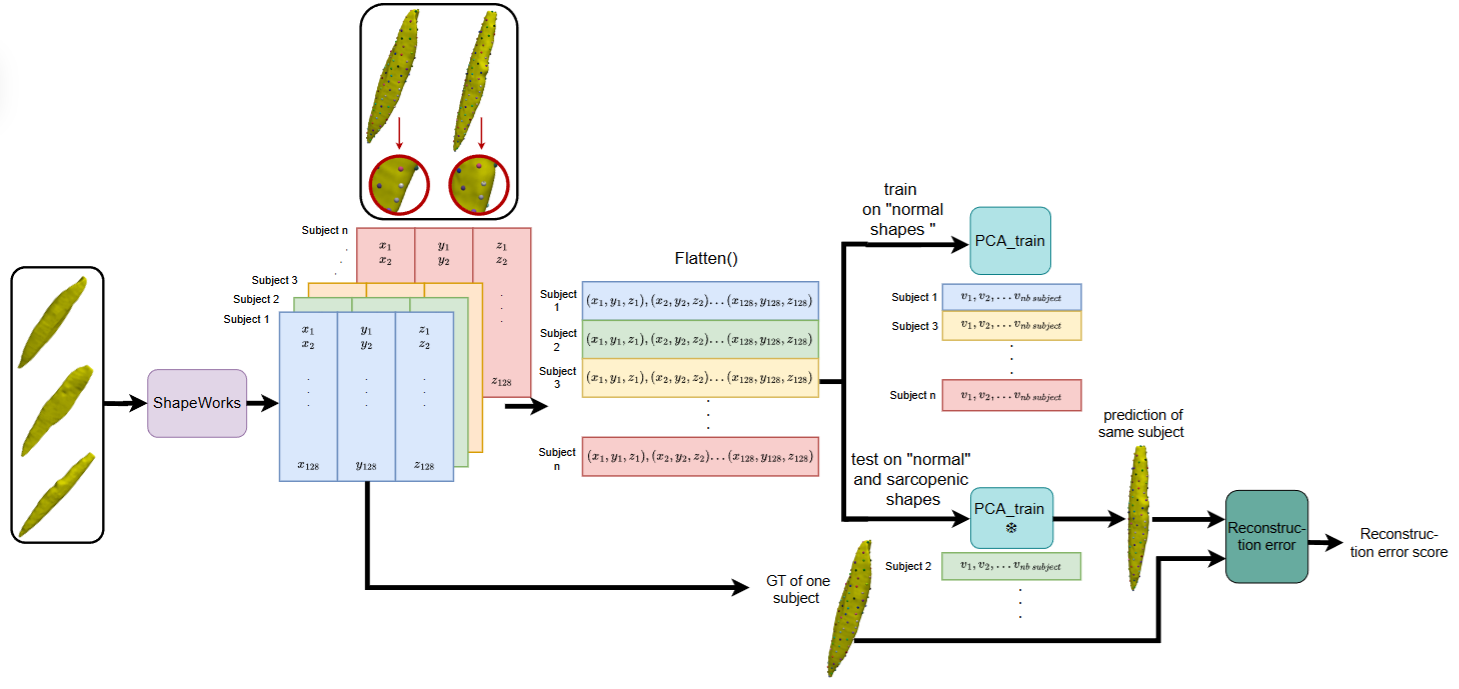
*Illustration du calcul de l’erreur de reconstruction à partir d’un modèle PCA entraîné sur les formes normales.*  

### Choix des composantes PCA  

Dans la méthode d’erreur de reconstruction, le **nombre de composantes PCA** retenu joue un rôle essentiel.  

- Si trop peu de composantes sont utilisées, l’espace construit ne capture pas suffisamment de variabilité et la reconstruction devient trop approximative.  
- Si trop de composantes sont retenues, le modèle risque de surajuster les données, et la distinction entre les groupes peut être moins marquée.  

Il est donc nécessaire de choisir un **nombre de composantes optimal** : celui qui permet une bonne reconstruction des formes tout en maximisant la **séparation entre les groupes**.  
Dans notre cas, ce choix est particulièrement important pour distinguer les sujets âgés avec sarcopénie des sujets âgés sans sarcopénie.  


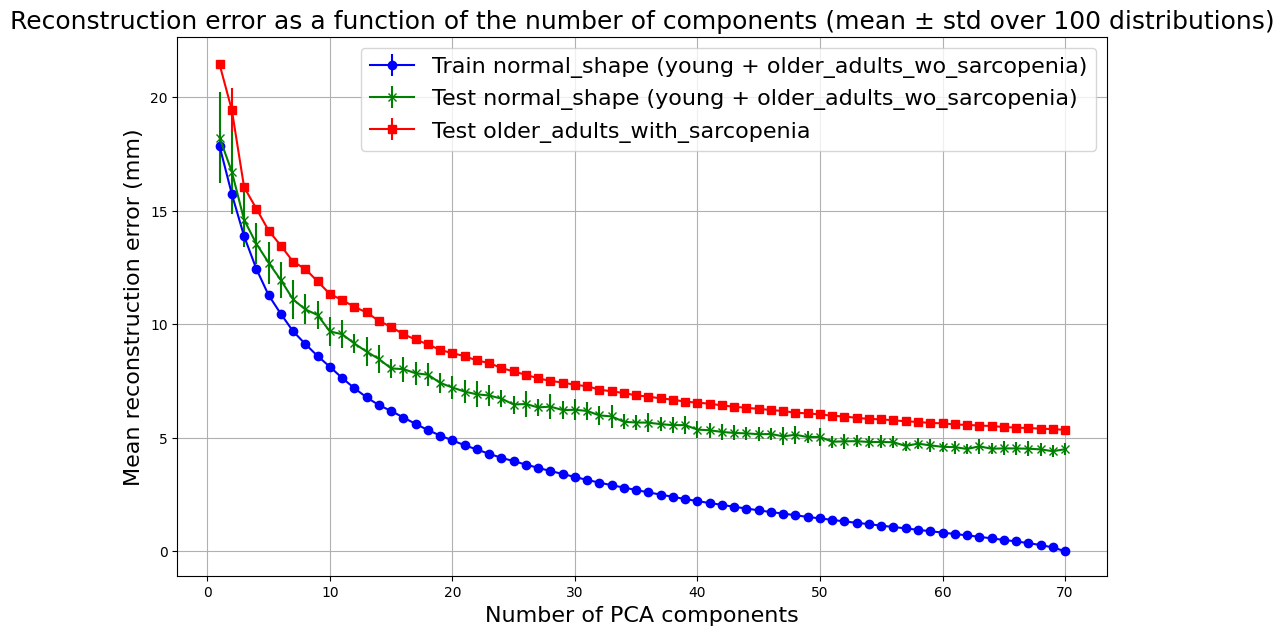

Meilleur écart moyen entre les formes normales et sarcopéniques pour la composante PCA n°1 (index 0)


In [ ]:
# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# # TA : Répertoires pour le muscle TA (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL : Répertoires pour le muscle VL (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
# 1. Chargement des données
# Chargement des particules pour chaque groupe (sarcopénie, jeunes, vieux)
# sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
# n, p, d = sarcopenie_parts_128.shape  # n: nombre d'échantillons, p: nombre de points, d: dimension (3D)
# sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)  # Aplatir pour PCA

# jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
# n, p, d = jeunes_parts_128.shape
# jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)

# vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
# n, p, d = vieu_parts_128.shape
# vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Initialisation des listes pour stocker les erreurs
errors_train_tot= []
errors_test_tot= []
errors_sarcoppenie_tot= []
errors_vieux_tot= []

# Préparation pour l'affichage de l'erreur de reconstruction moyenne et écart-type en fonction du nombre de composantes PCA
parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
n_components_list = np.arange(1, min(int(parts_flat_128.shape[0]*0.9), parts_flat_128.shape[1]), 1)
mean_errors_train = []
std_errors_train = []
mean_errors_test = []
std_errors_test = []
mean_errors_sarcopenie = []
std_errors_sarcopenie = []
mean_errors_vieux = []
std_errors_vieux = []

distribution = 30  # Nombre de distributions pour la moyenne/écart-type

for n_components in n_components_list:
    errors_train_dist = []
    errors_test_dist = []
    errors_sarcopenie_dist = []
    errors_vieux_dist = []
    for i in range(distribution):
        # Combine les données jeunes et vieux
        parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
        label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: jeunes, 1: vieux

        # Séparation en train/test (stratifiée)
        X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1, stratify=label_128)
        label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128))  # 2: sarcopénie

        # PCA sur les données d'entraînement
        pca = PCA(n_components=n_components)
        pca.fit(X_train_128)
        
        # Fonction pour calculer l'erreur de reconstruction
        def reconstruction_error(X, model):
            X_reduced = model.transform(X)
            X_rec = model.inverse_transform(X_reduced)
            return np.linalg.norm(X - X_rec, axis=1)
        
        # Calcul des erreurs de reconstruction pour chaque groupe
        errors_train = reconstruction_error(X_train_128, pca)
        errors_test = reconstruction_error(X_test_128, pca)
        errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat_128, pca)
        
        # Moyenne des erreurs pour cette distribution
        errors_train_dist.append(np.mean(errors_train))
        errors_test_dist.append(np.mean(errors_test))
        errors_sarcopenie_dist.append(np.mean(errors_sarcopenie))

    # Moyenne et écart-type sur toutes les distributions pour chaque nombre de composantes
    mean_errors_train.append(np.mean(errors_train_dist))
    std_errors_train.append(np.std(errors_train_dist))
    mean_errors_test.append(np.mean(errors_test_dist))
    std_errors_test.append(np.std(errors_test_dist))
    mean_errors_sarcopenie.append(np.mean(errors_sarcopenie_dist))
    std_errors_sarcopenie.append(np.std(errors_sarcopenie_dist))

# Affichage des courbes d'erreur de reconstruction
plt.figure(figsize=(12, 7))
plt.errorbar(n_components_list, mean_errors_train, yerr=std_errors_train, label='Train normal_shape (young + older_adults_wo_sarcopenia)', marker='o', color='blue')
plt.errorbar(n_components_list, mean_errors_test, yerr=std_errors_test, label='Test normal_shape (young + older_adults_wo_sarcopenia)', marker='x', color='green')
plt.errorbar(n_components_list, mean_errors_sarcopenie, yerr=std_errors_sarcopenie, label='Test older_adults_with_sarcopenia', marker='s', color='red')
plt.xlabel("Number of PCA components", fontsize=16)
plt.ylabel("Mean reconstruction error (mm)", fontsize=16)
plt.title("Reconstruction error as a function of the number of components (mean ± std over 100 distributions)", fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_all_compenants_VL.pdf", format='pdf', bbox_inches='tight')

plt.show()

dif = np.array(mean_errors_test) - np.array(mean_errors_sarcopenie)
# Trouver la composante avec le plus grand écart moyen entre normal et sarcopéniques
best_idx = np.argmax(np.abs(dif))
print(f"Meilleur écart moyen entre les formes normales et sarcopéniques pour la composante PCA n°{n_components_list[best_idx]} (index {best_idx})")



moyenne d'âge sains : 51.95
moyenne d'âge sarcopenie : 88.00
Erreur de reconstruction moyenne : 9.7746
Erreur de reconstruction moyenne : 12.4958
Erreur de reconstruction moyenne : 13.9816


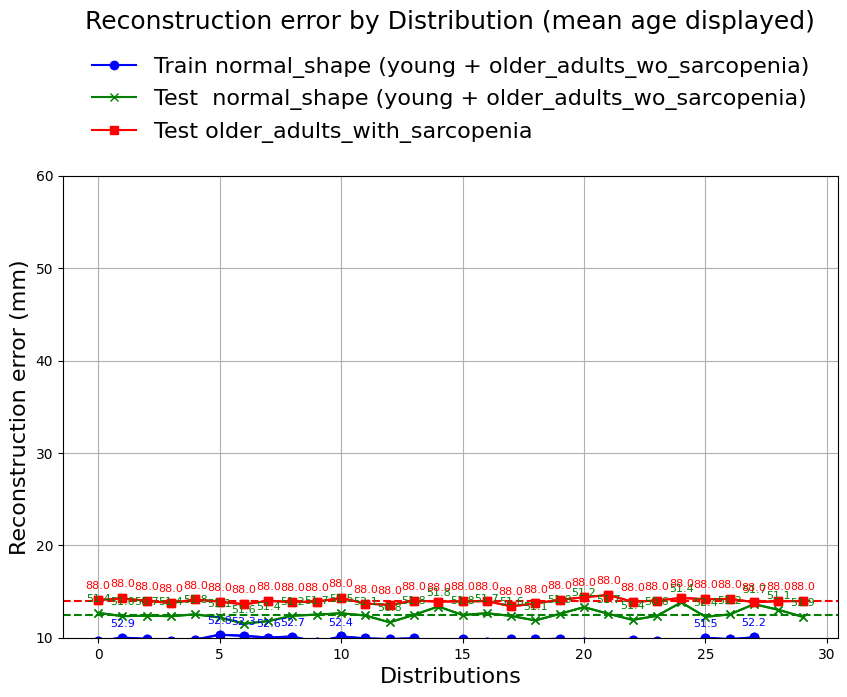

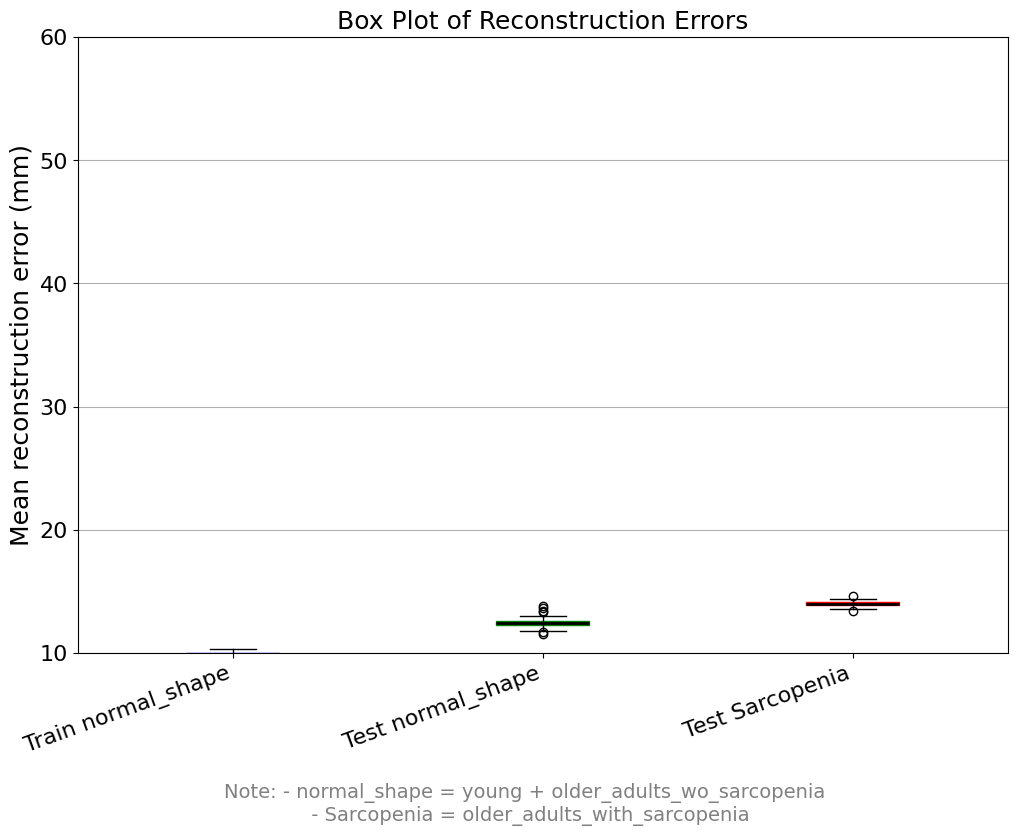

In [ ]:
# Charger le fichier Excel contenant les âges (remplace le chemin par le tien)
excel_path = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/age_global.xlsx"
df_ages = pd.read_excel(excel_path)

# Supposons que la colonne des noms s'appelle 'Nom' et celle des âges 'Age'
# Associe les âges aux noms des sujets sarcopenie, jeunes et vieux
def get_ages(names, df_ages):
    ages = []

    for name in names:
        match_id = None
        # On cherche un ID_subject du DataFrame qui est contenu dans le nom
        for id_ in df_ages['ID_subject']:
            if id_.split("_")[0] in name.split("_"):
                match_id = id_
                break
        if match_id:
            age = df_ages.loc[df_ages['ID_subject'] == match_id, 'Age'].values[0]
            ages.append(age)
        else:
            print(f"ID non trouvé pour: {name}")
            ages.append(None)

    # Convertir les âges en int (en ignorant les None)
    ages = [int(age) if age is not None else None for age in ages]
    return ages

# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# # TA : Répertoires pour le muscle TA (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL : Répertoires pour le muscle VL (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"

# 1. Chargement des données
# On charge les particules et les noms pour chaque groupe (sarcopénie, jeunes, vieux)
sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # n: nb sujets, p: nb points, d: dimension (3D)
ages_sarcopenie = get_ages(sarcopenie_names, df_ages)
sarcopenie_parts_flat_128 = (sarcopenie_parts_128.reshape(n, -1), sarcopenie_names, ages_sarcopenie)

jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape
ages_jeunes = get_ages(jeunes_names, df_ages)
jeunes_parts_flat_128 = (jeunes_parts_128.reshape(n, -1), jeunes_names, ages_jeunes)

vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape
ages_vieux = get_ages(vieu_names, df_ages)
vieu_parts_flat_128 = (vieu_parts_128.reshape(n, -1), vieu_names, ages_vieux)

# Calcul des âges valides (non None) pour les groupes sains et sarcopénie
ages_sains = jeunes_parts_flat_128[2] + vieu_parts_flat_128[2]
X_ages_valid = [age for age in ages_sains if age is not None]
sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat_128[2] if age is not None]
print(f"moyenne d'âge sains : {np.mean(X_ages_valid):.2f}")
print(f"moyenne d'âge sarcopenie : {np.mean(sarcopenie_ages_valid):.2f}")

# Initialisation des listes pour stocker les erreurs et moyennes d'âge
errors_train_tot= []
errors_test_tot= []
errors_sarcoppenie_tot= []
errors_jeunes_tot= []
train_ages_means = []
test_ages_means = []
sarcopenie_ages_means = []
jeunes_ages_means = []
distribution= 30

# 2. Split jeunes pour train/test
for i in range(distribution):
    # Combine les données jeunes et âgées pour le split
    X_data = np.vstack((jeunes_parts_flat_128[0], vieu_parts_flat_128[0]))
    X_names = jeunes_parts_flat_128[1] + vieu_parts_flat_128[1]
    X_ages = jeunes_parts_flat_128[2] + vieu_parts_flat_128[2]
    label_128 = np.array([0] * len(jeunes_parts_flat_128[0]) + [1] * len(vieu_parts_flat_128[0]))  # 0: jeunes, 1: âgés

    label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128[0]))  # 2: sarcopénie
    # Split des données en train/test (50/50 ici, stratifié)
    X_train_128, X_test_128, y_train_128, y_test_128, train_names, test_names, train_ages, test_ages = train_test_split(
        X_data, label_128, X_names, X_ages, test_size=0.5, stratify=label_128
    )

    # 3. PCA
    n_components = 6  #6 pour RF et 2 pour TA nombre de composantes principales à garder
    pca = PCA(n_components=n_components)
    pca.fit(X_train_128)

    # 4. Fonction de reconstruction + erreur
    def reconstruction_error(X, model):
        X_reduced = model.transform(X)
        X_rec = model.inverse_transform(X_reduced)
        return np.linalg.norm(X - X_rec, axis=1)  # Erreur L2 par échantillon

    # 5. Calcul des erreurs de reconstruction pour chaque groupe
    errors_train = reconstruction_error(X_train_128, pca)
    errors_test = reconstruction_error(X_test_128, pca)
    errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat_128[0], pca)
    
    # Calcul des moyennes d'âge valides pour chaque split
    train_ages_valid = [age for age in train_ages if age is not None]
    test_ages_valid = [age for age in test_ages if age is not None]
    sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat_128[2] if age is not None]

    train_ages_means.append(np.mean(train_ages_valid) if train_ages_valid else np.nan)
    test_ages_means.append(np.mean(test_ages_valid) if test_ages_valid else np.nan)
    sarcopenie_ages_means.append(np.mean(sarcopenie_ages_valid) if sarcopenie_ages_valid else np.nan)
    
    # Stockage des erreurs pour analyse ultérieure
    errors_train_tot.append(errors_train)
    errors_test_tot.append(errors_test)
    errors_sarcoppenie_tot.append(errors_sarcopenie)
    errors_train =[]
    errors_test =[]
    errors_sarcopenie =[]
    
print(f"Erreur de reconstruction moyenne : {np.mean(errors_train_tot):.4f}")
print(f"Erreur de reconstruction moyenne : {np.mean(errors_test_tot):.4f}")    
print(f"Erreur de reconstruction moyenne : {np.mean(errors_sarcoppenie_tot):.4f}")

# 6. Affichage des erreurs de reconstruction par split/distribution
plt.figure(figsize=(10, 6))
x = range(distribution)
plt.plot(x, [np.mean(err) for err in errors_train_tot], label='Train normal_shape (young + older_adults_wo_sarcopenia)', marker='o', color='blue')
plt.plot(x, [np.mean(err) for err in errors_test_tot], label='Test  normal_shape (young + older_adults_wo_sarcopenia)', marker='x', color='green')
plt.plot(x, [np.mean(err) for err in errors_sarcoppenie_tot], label='Test older_adults_with_sarcopenia', marker='s', color='red')
# Affichage de la moyenne d'âge sur chaque point
for i in x:
    plt.annotate(f"{train_ages_means[i]:.1f}", (i, np.mean(errors_train_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='blue', fontsize=8)
    plt.annotate(f"{test_ages_means[i]:.1f}", (i, np.mean(errors_test_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='green', fontsize=8)
    plt.annotate(f"{sarcopenie_ages_means[i]:.1f}", (i, np.mean(errors_sarcoppenie_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='red', fontsize=8)

plt.plot(range(len(errors_train_tot)), [np.mean(err) for err in errors_train_tot], marker='o', color='blue')
plt.plot(range(len(errors_test_tot)), [np.mean(err) for err in errors_test_tot], marker='x', color='green')
plt.plot(range(len(errors_sarcoppenie_tot)), [np.mean(err) for err in errors_sarcoppenie_tot], marker='s', color='red')
plt.axhline(y=np.mean([np.mean(err) for err in errors_train_tot]), color='blue', linestyle='--')
plt.axhline(y=np.mean([np.mean(err) for err in errors_test_tot]), color='green', linestyle='--')
plt.axhline(y=np.mean([np.mean(err) for err in errors_sarcoppenie_tot]), color='red', linestyle='--')
plt.xlabel("Distributions", fontsize=16)
plt.ylabel("Reconstruction error (mm)", fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=1, frameon=False, fontsize=16)
plt.title("Reconstruction error by Distribution (mean age displayed)", fontsize=18, y=1.3)
plt.ylim(10, 60)
plt.grid()
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_by_distribution_VL.pdf", format='pdf', bbox_inches='tight')
plt.show()

# 7. Affichage des erreurs de reconstruction sous forme de boxplot
plt.figure(figsize=(12, 8))

data = [
    [np.mean(err) for err in errors_train_tot],
    [np.mean(err) for err in errors_test_tot],
    [np.mean(err) for err in errors_sarcoppenie_tot],
]

# labels = [
#     "Train normal_shape \n(young + older_adults_wo_sarcopenia)",
#     "Test normal_shape \n(young + older_adults_wo_sarcopenia)",
#     "Test (older_adults_with_sarcopenia)"
# ]

labels = [
    "Train normal_shape",
    "Test normal_shape",
    "Test Sarcopenia"
]

colors = ["blue", "green", "red"]

bp = plt.boxplot(data, labels=labels, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)

for median, color in zip(bp['medians'], colors):
    median.set(color='black', linewidth=2)  # median en noir pour contraste

plt.title("Box Plot of Reconstruction Errors", fontsize=18)
plt.ylabel("Mean reconstruction error (mm)", fontsize=18)
# Rotation et taille des labels
plt.gca().tick_params(axis='x', labelrotation=20)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_fontsize(16)
    tick.set_horizontalalignment('right')  # Aligne la fin du mot avec le trait du boxplot
plt.ylim(5, 40)
plt.grid(axis="y")
plt.figtext(0.5, -0.1, "Note: - normal_shape = young + older_adults_wo_sarcopenia \n - Sarcopenia = older_adults_with_sarcopenia", ha="center", fontsize=14, color="gray")
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_box_plot_VL.pdf", format='pdf', bbox_inches='tight')
plt.show()


### Affichage box plot ensemble

Train RF shape: (30, 40)
Test RF shape: (30, 40)
Sarcopenie RF shape: (30, 24)
     Muscle      Error       Group    Fold      Subject
0        RF  47.895659     healthy   Fold1   RF_test_S1
1        RF  65.461737     healthy   Fold1   RF_test_S2
2        RF  49.534637     healthy   Fold1   RF_test_S3
3        RF  33.884383     healthy   Fold1   RF_test_S4
4        RF  52.968537     healthy   Fold1   RF_test_S5
...     ...        ...         ...     ...          ...
5605     VL  39.969783  sarcopenia  Fold30  VL_sarc_S19
5606     VL  21.490680  sarcopenia  Fold30  VL_sarc_S20
5607     VL  30.610839  sarcopenia  Fold30  VL_sarc_S21
5608     VL  27.961740  sarcopenia  Fold30  VL_sarc_S22
5609     VL  44.129340  sarcopenia  Fold30  VL_sarc_S23

[5610 rows x 5 columns]

--- LMM Results for RF (healthy + sarcopenia) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Error     
No. Observations:   1920      Method:               REML    

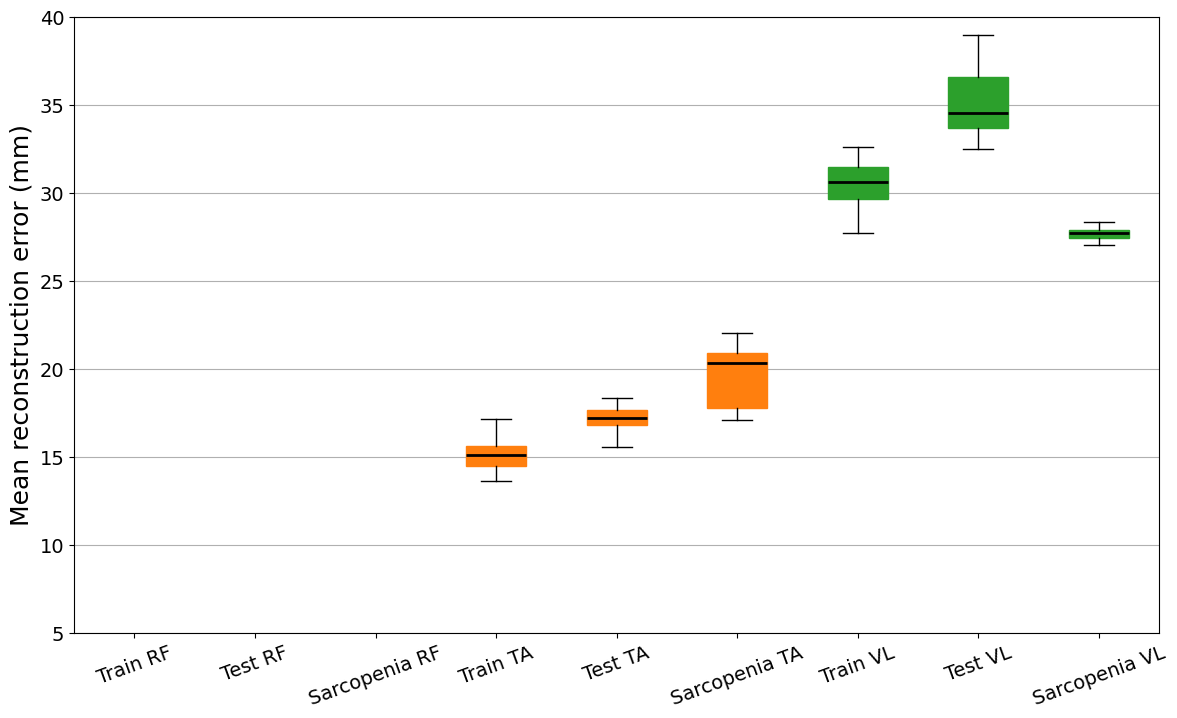

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def compute_reconstruction_errors(particles_dir_sarcopenie, particles_dir_jeunes, particles_dir_vieux, df_ages, distribution=30, n_components=6):
    """
    Calcule les erreurs de reconstruction PCA pour différents groupes de particules.
    
    Args:
        particles_dir_sarcopenie (str): Répertoire des fichiers de particules sarcopénie.
        particles_dir_jeunes (str): Répertoire des fichiers de particules jeunes.
        particles_dir_vieux (str): Répertoire des fichiers de particules vieux.
        df_ages (DataFrame): DataFrame contenant les âges.
        distribution (int, optional): Nombre de splits train/test à réaliser. Default à 30.
        n_components (int, optional): Nombre de composantes principales pour la PCA. Default à 6.
    
    Returns:
        dict: Dictionnaire contenant les erreurs et les moyennes d'âge.
    """
    
    # --- Chargement des données ---
    sarcopenie_parts, sarcopenie_names = get_particles(particles_dir_sarcopenie, "world")
    n, p, d = sarcopenie_parts.shape
    ages_sarcopenie = get_ages(sarcopenie_names, df_ages)
    sarcopenie_parts_flat = (sarcopenie_parts.reshape(n, -1), sarcopenie_names, ages_sarcopenie)

    jeunes_parts, jeunes_names = get_particles(particles_dir_jeunes, "world")
    n, p, d = jeunes_parts.shape
    ages_jeunes = get_ages(jeunes_names, df_ages)
    jeunes_parts_flat = (jeunes_parts.reshape(n, -1), jeunes_names, ages_jeunes)

    vieux_parts, vieux_names = get_particles(particles_dir_vieux, "world")
    n, p, d = vieux_parts.shape
    ages_vieux = get_ages(vieux_names, df_ages)
    vieux_parts_flat = (vieux_parts.reshape(n, -1), vieux_names, ages_vieux)

    # --- Fonction de reconstruction et calcul d'erreur ---
    def reconstruction_error(X, model):
        X_reduced = model.transform(X)
        X_rec = model.inverse_transform(X_reduced)
        return np.linalg.norm(X - X_rec, axis=1)
    
    # Initialisation des listes pour stocker les résultats
    errors_train_tot = []
    errors_test_tot = []
    errors_sarcopenie_tot = []
    train_ages_means = []
    test_ages_means = []
    sarcopenie_ages_means = []

    # --- Boucle sur les splits ---
    for _ in range(distribution):
        X_data = np.vstack((jeunes_parts_flat[0], vieux_parts_flat[0]))
        X_names = jeunes_parts_flat[1] + vieux_parts_flat[1]
        X_ages = jeunes_parts_flat[2] + vieux_parts_flat[2]
        label_128 = np.array([0] * len(jeunes_parts_flat[0]) + [1] * len(vieux_parts_flat[0]))

        # Split train/test
        X_train, X_test, y_train, y_test, train_names, test_names, train_ages, test_ages = train_test_split(
            X_data, label_128, X_names, X_ages, test_size=0.5, stratify=label_128
        )

        # PCA
        pca = PCA(n_components=n_components)
        pca.fit(X_train)

        # Calcul des erreurs
        errors_train = reconstruction_error(X_train, pca)
        errors_test = reconstruction_error(X_test, pca)
        errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat[0], pca)

        # Moyennes d'âge valides
        train_ages_valid = [age for age in train_ages if age is not None]
        test_ages_valid = [age for age in test_ages if age is not None]
        sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat[2] if age is not None]

        train_ages_means.append(np.mean(train_ages_valid) if train_ages_valid else np.nan)
        test_ages_means.append(np.mean(test_ages_valid) if test_ages_valid else np.nan)
        sarcopenie_ages_means.append(np.mean(sarcopenie_ages_valid) if sarcopenie_ages_valid else np.nan)

        # Stockage des erreurs
        errors_train_tot.append(errors_train)
        errors_test_tot.append(errors_test)
        errors_sarcopenie_tot.append(errors_sarcopenie)

    return {
        "errors_train": errors_train_tot,
        "errors_test": errors_test_tot,
        "errors_sarcopenie": errors_sarcopenie_tot,
        "train_ages_means": train_ages_means,
        "test_ages_means": test_ages_means,
        "sarcopenie_ages_means": sarcopenie_ages_means
    }




# Charger le fichier Excel contenant les âges
excel_path = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/age_global.xlsx"
df_ages = pd.read_excel(excel_path)

# Fonction pour associer les âges aux noms
def get_ages(names, df_ages):
    ages = []
    for name in names:
        match_id = None
        for id_ in df_ages['ID_subject']:
            if id_.split("_")[0] in name.split("_"):
                match_id = id_
                break
        if match_id:
            age = df_ages.loc[df_ages['ID_subject'] == match_id, 'Age'].values[0]
            ages.append(age)
        else:
            print(f"ID non trouvé pour: {name}")
            ages.append(None)
    return [int(age) if age is not None else None for age in ages]

# Chemins des données (adapter selon le muscle voulu)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
}


# Appel de la fonction
errors_dict_RF = compute_reconstruction_errors(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

errors_dict_TA = compute_reconstruction_errors(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

errors_dict_VL = compute_reconstruction_errors(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

# Récupération des erreurs pour chaque muscle
errors_train_tot_RF = errors_dict_RF["errors_train"]
errors_test_tot_RF = errors_dict_RF["errors_test"]
errors_sarcopenie_tot_RF = errors_dict_RF["errors_sarcopenie"]

errors_train_tot_TA = errors_dict_TA["errors_train"]
errors_test_tot_TA = errors_dict_TA["errors_test"]
errors_sarcopenie_tot_TA = errors_dict_TA["errors_sarcopenie"]

errors_train_tot_VL = errors_dict_VL["errors_train"]
errors_test_tot_VL = errors_dict_VL["errors_test"]
errors_sarcopenie_tot_VL = errors_dict_VL["errors_sarcopenie"]

# Vérification des shapes pour s'assurer que tout est correct
print("Train RF shape:", np.array(errors_train_tot_RF).shape)
print("Test RF shape:", np.array(errors_test_tot_RF).shape)
print("Sarcopenie RF shape:", np.array(errors_sarcopenie_tot_RF).shape)


# Erreurs moyennes (exemple avec RF, à adapter selon tes variables)
mean_errors_train_muscle = [
    [np.mean(err) for err in errors_train_tot_RF],
    [np.mean(err) for err in errors_train_tot_TA],
    [np.mean(err) for err in errors_train_tot_VL],
]

mean_errors_test_muscle = [
    [np.mean(err) for err in errors_test_tot_RF],
    [np.mean(err) for err in errors_test_tot_TA],
    [np.mean(err) for err in errors_test_tot_VL],
]

mean_errors_sarcopenie_muscle = [
    [np.mean(err) for err in errors_sarcopenie_tot_RF],
    [np.mean(err) for err in errors_sarcopenie_tot_TA],
    [np.mean(err) for err in errors_sarcopenie_tot_VL],
]



muscle_labels = ['RF', 'TA', 'VL']
muscle_colors = ["#8EB0FF", '#ff7f0e', '#2ca02c']

# # --- Figure 1 : Erreur par distribution pour chaque muscle ---
# plt.figure(figsize=(12, 7))
# for idx, muscle in enumerate(muscle_labels):
#     x = range(len(mean_errors_train_muscle[idx]))
#     plt.plot(x, mean_errors_train_muscle[idx], label=f'Train {muscle}', marker='o', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_test_muscle[idx], label=f'Test {muscle}', marker='x', linestyle='--', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_sarcopenie_muscle[idx], label=f'Sarcopenia {muscle}', marker='s', linestyle=':', color=muscle_colors[idx])

# plt.xlabel("Distributions", fontsize=16)
# plt.ylabel("Reconstruction error (mm)", fontsize=16)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False, fontsize=14)
# plt.title("Reconstruction error by Distribution for RF, TA, VL", fontsize=18, y=1.08)
# plt.ylim(10, 40)
# plt.grid()
# plt.savefig("error_by_distribution_RF_TA_VL.pdf", format='pdf', bbox_inches='tight')
# plt.show()


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# --- Concaténer toutes les erreurs en un seul DataFrame ---
records = []

for i, muscle in enumerate(muscle_labels):
    # Test
    for fold_idx, err_fold in enumerate(errors_test_tot_RF if muscle=="RF" else errors_test_tot_TA if muscle=="TA" else errors_test_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "healthy",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_test_S{subj_idx+1}"
            })
    # Sarcopenia
    for fold_idx, err_fold in enumerate(errors_sarcopenie_tot_RF if muscle=="RF" else errors_sarcopenie_tot_TA if muscle=="TA" else errors_sarcopenie_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "sarcopenia",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_sarc_S{subj_idx+1}"
            })

df_test_sarc = pd.DataFrame.from_records(records)
print(df_test_sarc)

# Convertir en catégorie pour statsmodels
df_test_sarc["Group"] = df_test_sarc["Group"].astype("category")
df_test_sarc["Fold"] = df_test_sarc["Fold"].astype("category")
df_test_sarc["Subject"] = df_test_sarc["Subject"].astype("category")

# --- LMM par muscle uniquement sur test et sarcopenia ---
lmm_results = {}
for muscle in muscle_labels:
    df_m = df_test_sarc[df_test_sarc["Muscle"] == muscle]
    model = mixedlm("Error ~ Group + Fold", df_m, groups=df_m["Subject"])
    result = model.fit()
    print(f"\n--- LMM Results for {muscle} (healthy + sarcopenia) ---")
    print(result.summary())
    lmm_results[muscle] = result
    p_value_group = result.pvalues["Group[T.sarcopenia]"]
    print(f"P-value exacte pour l'effet Group (healthy vs sarcopenia) : {p_value_group:.6f}")


# --- Figure 2 : Boxplot des erreurs ---
plt.figure(figsize=(14, 8))
data_box = (
    mean_errors_train_muscle[0] + mean_errors_test_muscle[0] + mean_errors_sarcopenie_muscle[0] +
    mean_errors_train_muscle[1] + mean_errors_test_muscle[1] + mean_errors_sarcopenie_muscle[1] +
    mean_errors_train_muscle[2] + mean_errors_test_muscle[2] + mean_errors_sarcopenie_muscle[2]
)

labels_box = [
    "Train RF", "Test RF", "Sarcopenia RF",
    "Train TA", "Test TA", "Sarcopenia TA",
    "Train VL", "Test VL", "Sarcopenia VL"
]

colors_box = muscle_colors[0:1]*3 + muscle_colors[1:2]*3 + muscle_colors[2:3]*3

# Restructurer les données par groupe
data = [
    mean_errors_train_muscle[0], mean_errors_test_muscle[0], mean_errors_sarcopenie_muscle[0],
    mean_errors_train_muscle[1], mean_errors_test_muscle[1], mean_errors_sarcopenie_muscle[1],
    mean_errors_train_muscle[2], mean_errors_test_muscle[2], mean_errors_sarcopenie_muscle[2]
]

bp = plt.boxplot(data, labels=labels_box, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

# plt.title("Box Plot of Reconstruction Errors for RF, TA, VL", fontsize=18)
plt.ylabel("Mean reconstruction error (mm)", fontsize=18)
plt.xticks(rotation=20, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(5, 40)
plt.grid(axis="y")
# plt.savefig("Cerror_box_plot_RF_TA_VL.pdf", format='pdf', bbox_inches='tight')
plt.savefig("C://Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_box_plot_RF_TA_VL.pdf", format='pdf', bbox_inches='tight')
plt.show()

from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, f_oneway
import numpy as np
import matplotlib.pyplot as plt

# # Exemple de données
# erreurs_sain = np.array(mean_errors_test_muscle[2])
# erreurs_sarcopenique = np.array(mean_errors_sarcopenie_muscle[2])

# # --- 1. Normalité ---
# print(shapiro(erreurs_sain))
# print(shapiro(erreurs_sarcopenique))

# # --- 2. Variance ---
# print(levene(erreurs_sain, erreurs_sarcopenique))

# # --- 3. Tests statistiques ---
# # t-test classique
# stat, p_ttest = ttest_ind(erreurs_sain, erreurs_sarcopenique)
# print("t-test p-value:", p_ttest)

# # Mann-Whitney
# stat, p_mw = mannwhitneyu(erreurs_sain, erreurs_sarcopenique)
# print("Mann-Whitney p-value:", p_mw)

# # Welch t-test
# stat, p_welch = ttest_ind(erreurs_sain, erreurs_sarcopenique, equal_var=False)
# print("Welch t-test p-value:", p_welch)

# # --- 4. ANOVA ---
# stat, p_anova = f_oneway(erreurs_sain, erreurs_sarcopenique)
# print("ANOVA p-value:", p_anova)

# # --- 5. Box plot ---
# data = [erreurs_sain, erreurs_sarcopenique]
# labels = ['Sain', 'Sarcopénique']

# fig, ax = plt.subplots()
# ax.boxplot(data, labels=labels)
# ax.set_ylabel("Erreur de reconstruction")

# # Ajouter la p-value ANOVA sur le plot
# y_max = max(np.max(erreurs_sain), np.max(erreurs_sarcopenique))
# ax.text(1.5, y_max*1.05, f'p (ANOVA) = {p_anova:.2e}', ha='center', fontsize=12)

# plt.show()

#### Pour un fold

Train RF shape: (30, 40)
Test RF shape: (30, 40)
Sarcopenie RF shape: (30, 24)
size errors_train_tot_RF: (24,)
size errors_train_tot_RF: (22,)
size errors_train_tot_RF: (23,)
     Muscle      Error       Group    Fold      Subject
0        RF  57.125471     healthy   Fold1   RF_test_S1
1        RF  35.088506     healthy   Fold1   RF_test_S2
2        RF  66.391834     healthy   Fold1   RF_test_S3
3        RF  71.567165     healthy   Fold1   RF_test_S4
4        RF  48.400122     healthy   Fold1   RF_test_S5
...     ...        ...         ...     ...          ...
5605     VL  38.682482  sarcopenia  Fold30  VL_sarc_S19
5606     VL  22.461954  sarcopenia  Fold30  VL_sarc_S20
5607     VL  31.781985  sarcopenia  Fold30  VL_sarc_S21
5608     VL  27.171547  sarcopenia  Fold30  VL_sarc_S22
5609     VL  42.728152  sarcopenia  Fold30  VL_sarc_S23

[5610 rows x 5 columns]

--- LMM Results for RF (healthy + sarcopenia) ---
            Mixed Linear Model Regression Results
Model:              MixedLM

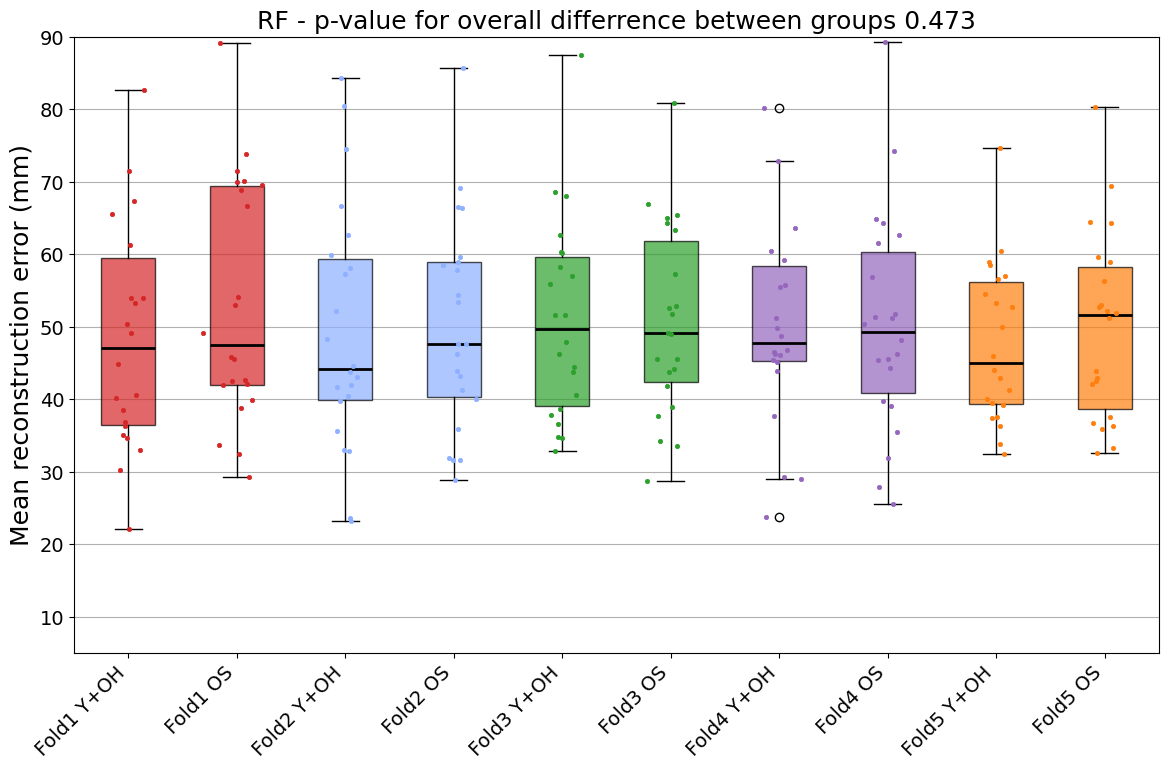

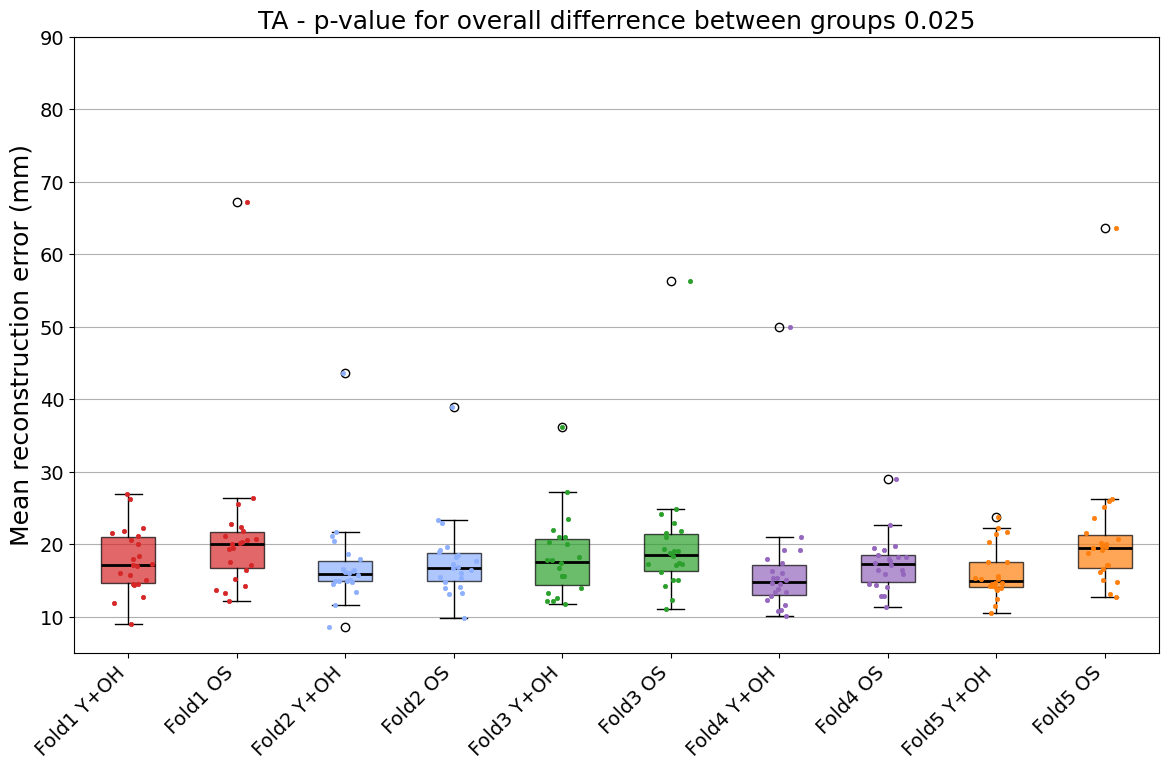

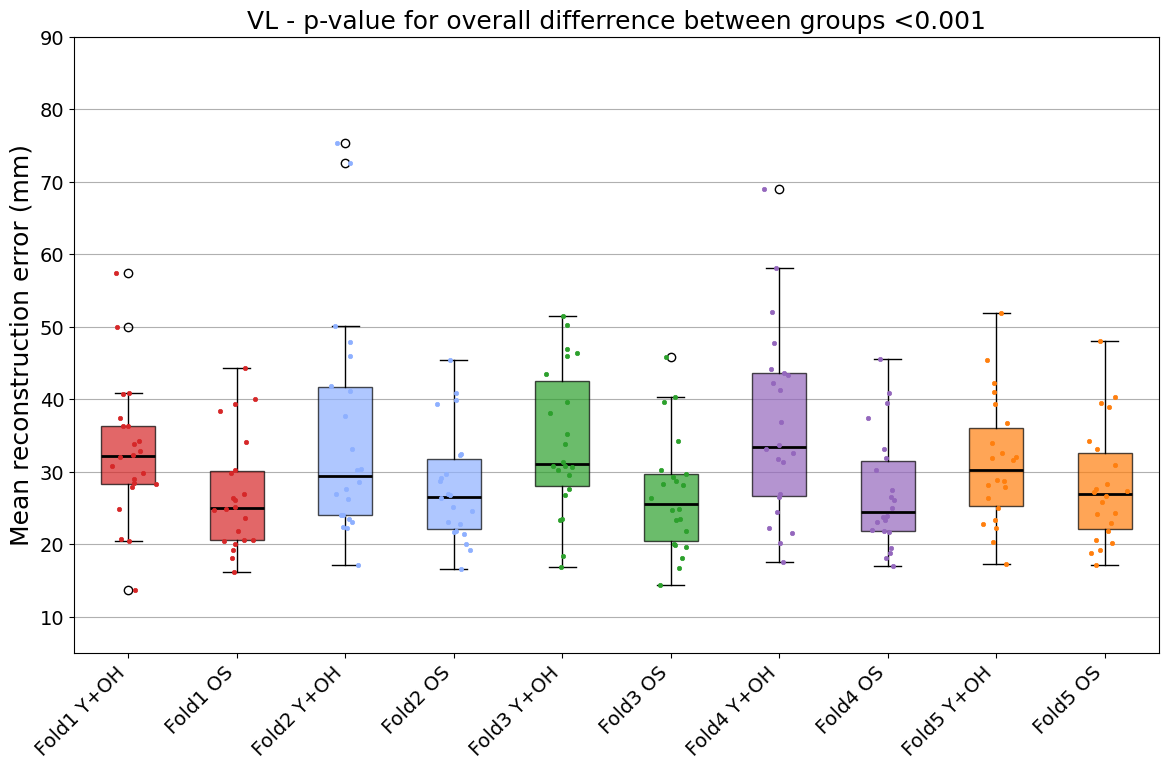

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def compute_reconstruction_errors(particles_dir_sarcopenie, particles_dir_jeunes, particles_dir_vieux, df_ages, distribution=30, n_components=6):
    """
    Calcule les erreurs de reconstruction PCA pour différents groupes de particules.
    
    Args:
        particles_dir_sarcopenie (str): Répertoire des fichiers de particules sarcopénie.
        particles_dir_jeunes (str): Répertoire des fichiers de particules jeunes.
        particles_dir_vieux (str): Répertoire des fichiers de particules vieux.
        df_ages (DataFrame): DataFrame contenant les âges.
        distribution (int, optional): Nombre de splits train/test à réaliser. Default à 30.
        n_components (int, optional): Nombre de composantes principales pour la PCA. Default à 6.
    
    Returns:
        dict: Dictionnaire contenant les erreurs et les moyennes d'âge.
    """
    
    # --- Chargement des données ---
    sarcopenie_parts, sarcopenie_names = get_particles(particles_dir_sarcopenie, "world")
    n, p, d = sarcopenie_parts.shape
    ages_sarcopenie = get_ages(sarcopenie_names, df_ages)
    sarcopenie_parts_flat = (sarcopenie_parts.reshape(n, -1), sarcopenie_names, ages_sarcopenie)

    jeunes_parts, jeunes_names = get_particles(particles_dir_jeunes, "world")
    n, p, d = jeunes_parts.shape
    ages_jeunes = get_ages(jeunes_names, df_ages)
    jeunes_parts_flat = (jeunes_parts.reshape(n, -1), jeunes_names, ages_jeunes)

    vieux_parts, vieux_names = get_particles(particles_dir_vieux, "world")
    n, p, d = vieux_parts.shape
    ages_vieux = get_ages(vieux_names, df_ages)
    vieux_parts_flat = (vieux_parts.reshape(n, -1), vieux_names, ages_vieux)

    # --- Fonction de reconstruction et calcul d'erreur ---
    def reconstruction_error(X, model):
        X_reduced = model.transform(X)
        X_rec = model.inverse_transform(X_reduced)
        return np.linalg.norm(X - X_rec, axis=1)
    
    # Initialisation des listes pour stocker les résultats
    errors_train_tot = []
    errors_test_tot = []
    errors_sarcopenie_tot = []
    train_ages_means = []
    test_ages_means = []
    sarcopenie_ages_means = []

    # --- Boucle sur les splits ---
    for _ in range(distribution):
        X_data = np.vstack((jeunes_parts_flat[0], vieux_parts_flat[0]))
        X_names = jeunes_parts_flat[1] + vieux_parts_flat[1]
        X_ages = jeunes_parts_flat[2] + vieux_parts_flat[2]
        label_128 = np.array([0] * len(jeunes_parts_flat[0]) + [1] * len(vieux_parts_flat[0]))

        # Split train/test
        X_train, X_test, y_train, y_test, train_names, test_names, train_ages, test_ages = train_test_split(
            X_data, label_128, X_names, X_ages, test_size=0.5, stratify=label_128
        )

        # PCA
        pca = PCA(n_components=n_components)
        pca.fit(X_train)

        # Calcul des erreurs
        errors_train = reconstruction_error(X_train, pca)
        errors_test = reconstruction_error(X_test, pca)
        errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat[0], pca)

        # Moyennes d'âge valides
        train_ages_valid = [age for age in train_ages if age is not None]
        test_ages_valid = [age for age in test_ages if age is not None]
        sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat[2] if age is not None]

        train_ages_means.append(np.mean(train_ages_valid) if train_ages_valid else np.nan)
        test_ages_means.append(np.mean(test_ages_valid) if test_ages_valid else np.nan)
        sarcopenie_ages_means.append(np.mean(sarcopenie_ages_valid) if sarcopenie_ages_valid else np.nan)

        # Stockage des erreurs
        errors_train_tot.append(errors_train)
        errors_test_tot.append(errors_test)
        errors_sarcopenie_tot.append(errors_sarcopenie)

    return {
        "errors_train": errors_train_tot,
        "errors_test": errors_test_tot,
        "errors_sarcopenie": errors_sarcopenie_tot,
        "train_ages_means": train_ages_means,
        "test_ages_means": test_ages_means,
        "sarcopenie_ages_means": sarcopenie_ages_means
    }




# Charger le fichier Excel contenant les âges
excel_path = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/age_global.xlsx"
df_ages = pd.read_excel(excel_path)

# Fonction pour associer les âges aux noms
def get_ages(names, df_ages):
    ages = []
    for name in names:
        match_id = None
        for id_ in df_ages['ID_subject']:
            if id_.split("_")[0] in name.split("_"):
                match_id = id_
                break
        if match_id:
            age = df_ages.loc[df_ages['ID_subject'] == match_id, 'Age'].values[0]
            ages.append(age)
        else:
            print(f"ID non trouvé pour: {name}")
            ages.append(None)
    return [int(age) if age is not None else None for age in ages]

# Chemins des données (adapter selon le muscle voulu)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
}


# Appel de la fonction
errors_dict_RF = compute_reconstruction_errors(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

errors_dict_TA = compute_reconstruction_errors(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

errors_dict_VL = compute_reconstruction_errors(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    df_ages=df_ages,
    distribution=30,
    n_components=2
)

# Récupération des erreurs pour chaque muscle
errors_train_tot_RF = errors_dict_RF["errors_train"]
errors_test_tot_RF = errors_dict_RF["errors_test"]
errors_sarcopenie_tot_RF = errors_dict_RF["errors_sarcopenie"]

errors_train_tot_TA = errors_dict_TA["errors_train"]
errors_test_tot_TA = errors_dict_TA["errors_test"]
errors_sarcopenie_tot_TA = errors_dict_TA["errors_sarcopenie"]

errors_train_tot_VL = errors_dict_VL["errors_train"]
errors_test_tot_VL = errors_dict_VL["errors_test"]
errors_sarcopenie_tot_VL = errors_dict_VL["errors_sarcopenie"]

# Vérification des shapes pour s'assurer que tout est correct
print("Train RF shape:", np.array(errors_train_tot_RF).shape)
print("Test RF shape:", np.array(errors_test_tot_RF).shape)
print("Sarcopenie RF shape:", np.array(errors_sarcopenie_tot_RF).shape)


# # Erreurs moyennes (exemple avec RF, à adapter selon tes variables)
# mean_errors_train_muscle = [
#     [np.mean(err) for err in errors_train_tot_RF],
#     [np.mean(err) for err in errors_train_tot_TA],
#     [np.mean(err) for err in errors_train_tot_VL],
# ]

# mean_errors_test_muscle = [
#     [np.mean(err) for err in errors_test_tot_RF],
#     [np.mean(err) for err in errors_test_tot_TA],
#     [np.mean(err) for err in errors_test_tot_VL],
# ]

# mean_errors_sarcopenie_muscle = [
#     [np.mean(err) for err in errors_sarcopenie_tot_RF],
#     [np.mean(err) for err in errors_sarcopenie_tot_TA],
#     [np.mean(err) for err in errors_sarcopenie_tot_VL],
# ]

print("size errors_train_tot_RF:", errors_sarcopenie_tot_RF[0].shape)
print("size errors_train_tot_RF:", errors_sarcopenie_tot_TA[0].shape)
print("size errors_train_tot_RF:", errors_sarcopenie_tot_VL[0].shape)
# Erreurs moyennes pour la première distribution uniquement
mean_errors_train_muscle = [
    errors_train_tot_RF[1][:22],    # première distribution RF
    errors_train_tot_TA[1][:22],    # première distribution TA
    errors_train_tot_VL[1][:22],    # première distribution VL
]

mean_errors_test_muscle = [
    errors_test_tot_RF[1][:22],     # première distribution RF
    errors_test_tot_TA[1][:22],     # première distribution TA
    errors_test_tot_VL[1][:22],     # première distribution VL
]

mean_errors_sarcopenie_muscle = [
    errors_sarcopenie_tot_RF[1][:22],   # première distribution RF
    errors_sarcopenie_tot_TA[1][:22],   # première distribution TA
    errors_sarcopenie_tot_VL[1][:22],   # première distribution VL
]


muscle_labels = ['RF', 'TA', 'VL']
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# def calculate_LMM()
# --- Concaténer toutes les erreurs en un seul DataFrame ---
records = []
p_value_group = []
for i, muscle in enumerate(muscle_labels):
    # Test
    for fold_idx, err_fold in enumerate(errors_test_tot_RF if muscle=="RF" else errors_test_tot_TA if muscle=="TA" else errors_test_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "healthy",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_test_S{subj_idx+1}"
            })
    # Sarcopenia
    for fold_idx, err_fold in enumerate(errors_sarcopenie_tot_RF if muscle=="RF" else errors_sarcopenie_tot_TA if muscle=="TA" else errors_sarcopenie_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "sarcopenia",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_sarc_S{subj_idx+1}"
            })

df_test_sarc = pd.DataFrame.from_records(records)
print(df_test_sarc)

# Convertir en catégorie pour statsmodels
df_test_sarc["Group"] = df_test_sarc["Group"].astype("category")
df_test_sarc["Fold"] = df_test_sarc["Fold"].astype("category")
df_test_sarc["Subject"] = df_test_sarc["Subject"].astype("category")

# --- LMM par muscle uniquement sur test et sarcopenia ---
lmm_results = {}
for muscle in muscle_labels:
    df_m = df_test_sarc[df_test_sarc["Muscle"] == muscle]
    model = mixedlm("Error ~ Group + Fold", df_m, groups=df_m["Subject"])
    result = model.fit()
    print(f"\n--- LMM Results for {muscle} (healthy + sarcopenia) ---")
    print(result.summary())
    lmm_results[muscle] = result
    p_value = result.pvalues["Group[T.sarcopenia]"]
    print(f"P-value exacte pour l'effet Group (healthy vs sarcopenia) : {p_value:.6f}")
    p_value_group.append("<0.001" if p_value < 0.001 else f"{p_value:.3f}")






muscle_labels = ['RF', 'TA', 'VL']
muscle_colors = ['#d62728', "#8EB0FF", '#2ca02c', '#9467bd', '#ff7f0e']

# # --- Figure 1 : Erreur par distribution pour chaque muscle ---
# plt.figure(figsize=(12, 7))
# for idx, muscle in enumerate(muscle_labels):
#     x = range(len(mean_errors_train_muscle[idx]))
#     plt.plot(x, mean_errors_train_muscle[idx], label=f'Train {muscle}', marker='o', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_test_muscle[idx], label=f'Test {muscle}', marker='x', linestyle='--', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_sarcopenie_muscle[idx], label=f'Sarcopenia {muscle}', marker='s', linestyle=':', color=muscle_colors[idx])

# plt.xlabel("Distributions", fontsize=16)
# plt.ylabel("Reconstruction error (mm)", fontsize=16)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False, fontsize=14)
# plt.title("Reconstruction error by Distribution for RF, TA, VL", fontsize=18, y=1.08)
# plt.ylim(10, 60)
# plt.grid()
# plt.savefig("error_by_distribution_RF_TA_VL.pdf", format='pdf', bbox_inches='tight')
# plt.show()

print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_train_muscle][0])
print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_test_muscle][0])
print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_sarcopenie_muscle][0])
# --- Figure 2 : Boxplot des erreurs ---

data_box = (
    mean_errors_train_muscle[0] + mean_errors_test_muscle[0] + mean_errors_sarcopenie_muscle[0] +
    mean_errors_train_muscle[1] + mean_errors_test_muscle[1] + mean_errors_sarcopenie_muscle[1] +
    mean_errors_train_muscle[2] + mean_errors_test_muscle[2] + mean_errors_sarcopenie_muscle[2]
)

# labels_box = [
#     "Train RF", "Test RF", "Sarcopenia RF",
#     "Train TA", "Test TA", "Sarcopenia TA",
#     "Train VL", "Test VL", "Sarcopenia VL"
# ]
# colors_box = muscle_colors[0:1]*3 + muscle_colors[1:2]*3 + muscle_colors[2:3]*3


labels_box = [
    "Fold1 Y+OH", "Fold1 OS",
    "Fold2 Y+OH", "Fold2 OS",
    "Fold3 Y+OH", "Fold3 OS",
    "Fold4 Y+OH", "Fold4 OS",
    "Fold5 Y+OH", "Fold5 OS",
]

colors_box = muscle_colors[0:1]*2 + muscle_colors[1:2]*2 + muscle_colors[2:3]*2+ muscle_colors[3:4]*2 + muscle_colors[4:5]*2

# Restructurer les données par groupe
# data = [
#     mean_errors_train_muscle[0], mean_errors_test_muscle[0], mean_errors_sarcopenie_muscle[0],
#     mean_errors_train_muscle[1], mean_errors_test_muscle[1], mean_errors_sarcopenie_muscle[1],
#     mean_errors_train_muscle[2], mean_errors_test_muscle[2], mean_errors_sarcopenie_muscle[2]
# ]

data = [[
    errors_test_tot_RF[1][:22],errors_sarcopenie_tot_RF[1][:22],
    errors_test_tot_RF[2][:22],errors_sarcopenie_tot_RF[2][:22],
    errors_test_tot_RF[3][:22],errors_sarcopenie_tot_RF[3][:22],
    errors_test_tot_RF[4][:22],errors_sarcopenie_tot_RF[4][:22],
    errors_test_tot_RF[5][:22],errors_sarcopenie_tot_RF[5][:22]],
    [
    errors_test_tot_TA[1][:22],errors_sarcopenie_tot_TA[1][:22],
    errors_test_tot_TA[2][:22],errors_sarcopenie_tot_TA[2][:22],
    errors_test_tot_TA[3][:22],errors_sarcopenie_tot_TA[3][:22],
    errors_test_tot_TA[4][:22],errors_sarcopenie_tot_TA[4][:22],
    errors_test_tot_TA[5][:22],errors_sarcopenie_tot_TA[5][:22]],
    [
    errors_test_tot_VL[1][:22],errors_sarcopenie_tot_VL[1][:22],
    errors_test_tot_VL[2][:22],errors_sarcopenie_tot_VL[2][:22],
    errors_test_tot_VL[3][:22],errors_sarcopenie_tot_VL[3][:22],
    errors_test_tot_VL[4][:22],errors_sarcopenie_tot_VL[4][:22],
    errors_test_tot_VL[5][:22],errors_sarcopenie_tot_VL[5][:22]]
]

for i in range(len(data)):
    plt.figure(figsize=(14, 8))
    bp = plt.boxplot(data[i], labels=labels_box, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')  # contour noir
        patch.set_alpha(0.7)          # couleur plus transparente
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    # plt.title("Box Plot of Reconstruction Errors for RF, TA, VL", fontsize=18)
    plt.title(f"{muscle_labels[i]} - p-value for overall differrence between groups {p_value_group[i]}", fontsize=18)
    plt.ylabel("Mean reconstruction error (mm)", fontsize=18)
    plt.xticks(rotation=45, fontsize=14, ha='right')
    plt.yticks(fontsize=14)
    # Ajoute quelques points sur chaque boxplot (jitter pour la visibilité)
    for u, group_data in enumerate(data[i]):
        # Jitter horizontal pour éviter la superposition
        x_jitter = np.random.normal(loc=u+1, scale=0.08, size=len(group_data))
        plt.scatter(x_jitter, group_data, color=colors_box[u], alpha=1, s=10, linewidth=0.5, zorder=3)
    plt.ylim(5, 90)
    plt.grid(axis="y")
    plt.savefig(f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_folds_{muscle_labels[i]}_PC2.pdf", format='pdf', bbox_inches='tight')
    plt.show()



# from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, f_oneway
# import numpy as np
# import matplotlib.pyplot as plt

# # Exemple de données
# for i in range(3):
#     erreurs_sain = np.array(mean_errors_test_muscle[i])
#     erreurs_sarcopenique = np.array(mean_errors_sarcopenie_muscle[i])

#     # --- 1. Normalité ---
#     print(shapiro(erreurs_sain))
#     print(shapiro(erreurs_sarcopenique))

#     # --- 2. Variance ---
#     print(levene(erreurs_sain, erreurs_sarcopenique))

#     # --- 3. Tests statistiques ---
#     # t-test classique
#     stat, p_ttest = ttest_ind(erreurs_sain, erreurs_sarcopenique)
#     print("t-test p-value:", p_ttest)

#     # Mann-Whitney
#     stat, p_mw = mannwhitneyu(erreurs_sain, erreurs_sarcopenique)
#     print("Mann-Whitney p-value:", p_mw)

#     # Welch t-test
#     stat, p_welch = ttest_ind(erreurs_sain, erreurs_sarcopenique, equal_var=False)
#     print("Welch t-test p-value:", p_welch)

#     # --- 4. ANOVA ---
#     stat, p_anova = f_oneway(erreurs_sain, erreurs_sarcopenique)
#     print("ANOVA p-value:", p_anova)

#     # --- 5. Box plot ---
#     data = [erreurs_sain, erreurs_sarcopenique]
#     labels = ['Sain', 'Sarcopénique']

#     fig, ax = plt.subplots()
#     ax.boxplot(data, labels=labels)
#     ax.set_ylabel("Erreur de reconstruction")

#     # Ajouter la p-value ANOVA sur le plot
#     y_max = max(np.max(erreurs_sain), np.max(erreurs_sarcopenique))
#     ax.text(1.5, y_max*1.05, f'p (ANOVA) = {p_anova:.2e}', ha='center', fontsize=12)

#     plt.show()


## Classification Supervisée

Cette méthode vise à construire un modèle prédictif permettant de classifier automatiquement un sujet en trois catégories :  
- **jeune**,  
- **âgé sans sarcopénie**,  
- **âgé avec sarcopénie**,  
à partir de la forme musculaire.  

Le pipeline comprend :  
1. Une **PCA** appliquée sur les formes pour capturer la variabilité globale.  
2. Une **LDA** pour améliorer la séparabilité des classes et réduire la dimensionnalité.  
3. L’entraînement d’un **classificateur de régression logistique** sur l’espace réduit afin de prédire la catégorie d’un nouveau sujet.  

Cette approche permet à la fois d’évaluer la pertinence des informations contenues dans la forme musculaire et de proposer une méthode de classification automatique potentiellement utilisable en pratique clinique.  

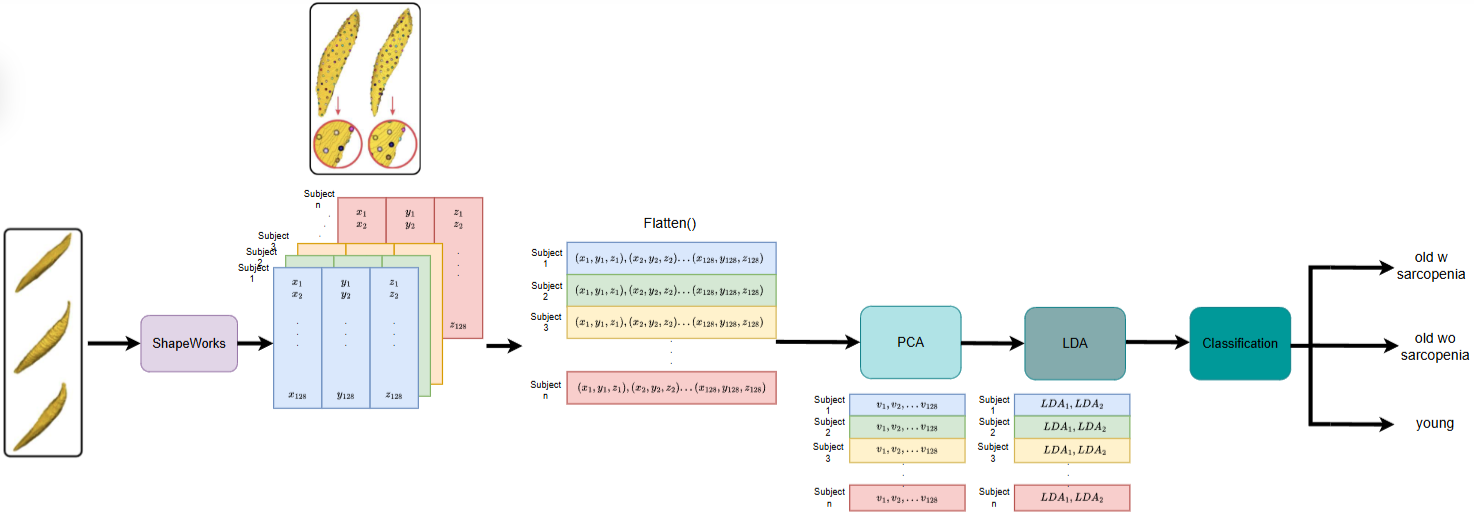
*Pipeline de classification supervisée des sujets en trois groupes à partir des points de correspondance.*  


In [ ]:
# Création de nouvelles données synthétiques
def augment_data(data, n_augment=2):
    # Ensure the input data is a NumPy array
    data = np.array(data)
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


# RF
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Sarcopenie_128"

sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d est la dimension de chaque particule
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d est la dimension de chaque particule
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d est la dimension de chaque particule
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# # # Paramètre de bruit (doit être ajusté selon tes données)
noise_level = 0.05  


# # Génération des nouvelles observations synthétiques
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augmente x2 les jeunes
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augmente x2 les vieux
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augmente x2 la sarcopénie

accuracy_tot=[]
score_tot=[]
y_true=[]
y_pred=[]
y_prob = []
y_true_tab=[]
y_pred_tab=[]
y_prob_tab = []
true=[]
pred = []
prob = []
aff_score= []
aff_score_tab = []
log_reg_coef_tab=[]
log_reg_coef = []
lda_coef_tab=[]
lda_coef = []
pca_coef_tab=[]

distribution = 30 # nombre d'ensembles de données à générer
for iteration in range(distribution):
    # Combine data for jeunes and vieux
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2, stratify=label_128)#, random_state=42)
    label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128))  # 0: jeunes, 1: vieux, 2: sarcopenie
    X_train_sarcopenie, X_test_sarcopenie, y_train_sarcopenie, y_test_sarcopenie = train_test_split(sarcopenie_parts_flat_128, label_sarcopenie, test_size=0.3)#, random_state=42)
    X_train_128 = np.vstack((X_train_128, X_train_sarcopenie))
    X_test_128 = np.vstack((X_test_128, X_test_sarcopenie))
    
    y_train_128 =  np.concatenate((y_train_128, y_train_sarcopenie))
    y_test_128 = np.concatenate((y_test_128, y_test_sarcopenie))

    # y_train_128 = np.random.randint(0, 3, size=len(X_train_128))  # Générer des étiquettes aléatoires entre 0 et 2
    # y_test_128 = np.random.randint(0, 3, size=len(X_test_128))  # Générer des étiquettes aléatoires entre 0 et 2
    # print(y_train_128.shape)
    # print(y_train_sarcopenie.shape)
    
    # X_augmented1 = generate_shapes(jeunes_parts_flat_128, num_particles=128, n_new=9, n_components=len(jeunes_parts_flat_128), variation_scale=3.0)
    # X_augmented2 = generate_shapes(vieu_parts_flat_128, num_particles=128, n_new=7, n_components=len(vieu_parts_flat_128), variation_scale=3.0)
    # X_augmented3 = generate_shapes(sarcopenie_parts_flat_128, num_particles=128, n_new=7, n_components=len(sarcopenie_parts_flat_128), variation_scale=3.0)    
    
    # X_train_128 = np.concatenate((X_train_128, X_augmented1, X_augmented2, X_augmented3))
    # y_train_128 =  np.concatenate((y_train_128, np.array([0] * len(X_augmented1) + [1] * len(X_augmented2)+ [2] * len(X_augmented3))))  # 0: jeunes, 1: vieux, 2: sarcopenie
    
    print(f"nb enssemble train : {len(X_train_128)}, nb ensemble test: {len(X_test_128)}")
    print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")
    # print(X_train_128.shape)
    # print(y_train_128.shape)

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    print(f"train nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    print(f"test nb jeunes : {count_jeunes}, nb vieux : {count_vieux}, nb sarcopenie : {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    print(f"max_components : {max_components}")
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Nombre de voisins pour le kNN
    cv_folds = 20  # Nombre de folds pour la validation croisée


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1) 
    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)


    for n in component_range:
        
        # max_components = 100

        # Ensure n_components for LDA is valid

        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(X_pca_128[:, :n], y_train_128)
        
        # Évaluer avec kNN
        
        # X_pca_test_128 = pca_128.transform(X_test_128)
        # X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :n])
        # score = silhouette_score(X_lda_test_128, y_test_128)
        # scores_128.append(score)
        # y_true.append(y_test_128)
        # y_pred.append(y_pred_128)
        # y_prob.append(log_reg_128.predict_proba(X_lda_test_128))
        # print(f"64 Particles , PCA={n} -> Accuracy kNN: {score:.4f}")

        # Train Logistic Regression on 128 particles
        X_pca_test_128 = pca_128.transform(X_test_128)
        X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :n])
        log_reg_128 = LogisticRegression(max_iter=10000, random_state=42)
        log_reg_128.fit(lda_projection_128, y_train_128)

        # Test Logistic Regression on 128 particles
        
        y_pred_128 = log_reg_128.predict(X_lda_test_128)
        accuracy = accuracy_score(y_test_128, y_pred_128)
        # accuracy = balanced_accuracy_score(y_test_128, y_pred_128) 
        f1 = f1_score(y_test_128, y_pred_128, average='micro')
        # print(f"F1_score : {f1:.4f}")
        recall = recall_score(y_test_128, y_pred_128, average='macro')
        f1_per_class = f1_score(y_test_128, y_pred_128, average=None)
        # print(f"F1_score per class : {f1_per_class}")
        # print(f"report : {classification_report(y_test_128, y_pred_128)}")
        recall_per_class = recall_score(y_test_128, y_pred_128, average=None)
        # accuracy_per_class = [accuracy_score(y_test_128[y_test_128 == i], y_pred_128[y_test_128 == i]) for i in np.unique(y_test_128)]
        accuracy_per_class = precision_score(y_test_128, y_pred_128, average=None, zero_division=0)

        # print(f"accuracy per class : {accuracy_per_class}")

        scores_128.append(f1)
        y_true_tab.append(y_test_128)
        y_pred_tab.append(y_pred_128)
        y_prob_tab.append(log_reg_128.predict_proba(X_lda_test_128))
        aff_score.append([f1, recall,accuracy, f1_per_class[0],f1_per_class[1], f1_per_class[2], 
                          recall_per_class[0], recall_per_class[1], recall_per_class[2], 
                          accuracy_per_class[0], accuracy_per_class[1], accuracy_per_class[2]])
        log_reg_coef.append(log_reg_128)
        lda_coef.append(lda_128)
    print(f"Meileure Composante : {component_range[np.argmax(scores_128)]}, score: {max(scores_128):.4f}")
    score_tot.append(scores_128)
    true.append(y_true_tab)
    pred.append(y_pred_tab)
    prob.append(y_prob_tab)
    aff_score_tab.append(aff_score)
    aff_score = []
    scores_128 = []
    print(f" taille lda coef : {len(lda_coef)}")
    
    log_reg_coef_tab.append(log_reg_coef)
    log_reg_coef = []
    lda_coef_tab.append(lda_coef)
    lda_coef = []
    pca_coef_tab.append(pca_128)
print(f"taille log reg : {len(lda_coef_tab)}")
# Trouver le nombre de composantes optimal
moyennes_scores = np.mean(score_tot, axis=0)
best_n_components_128 = component_range[np.argmax(moyennes_scores)]
best_score = max(moyennes_scores)
print(f"128 Particles ,Best Componante : {best_n_components_128}, score: {best_score:.4f}\n")
# Extract scores corresponding to the best number of components
best_scores = [scores[component_range.index(best_n_components_128)] for scores in score_tot]
# best_pca_coef = [scores[component_range.index(best_n_components_128)] for scores in pca_coef_tab]
best_reg_coef = [scores[component_range.index(best_n_components_128)] for scores in log_reg_coef_tab]
best_lda_coef = [scores[component_range.index(best_n_components_128)] for scores in lda_coef_tab]
y_true =  [scores[component_range.index(best_n_components_128)] for scores in true]
y_pred =  [scores[component_range.index(best_n_components_128)] for scores in pred]
y_prob =  [scores[component_range.index(best_n_components_128)] for scores in prob]
# Convert to a NumPy array for easier manipulation if needed
best_scores_array = np.array(best_scores)


# Calculer les moyennes et écarts types pour chaque métrique à travers les distributions
metrics = np.array(aff_score_tab)  # Convertir en tableau NumPy pour faciliter les calculs
means = metrics.mean(axis=0)  # Moyenne pour chaque métrique
stds = metrics.std(axis=0)  # Écart type pour chaque métrique

# Extraire les métriques
accuracy_means = means[:, 2]*100
recall_means = means[:, 1]*100
f1_score_means = means[:, 0]*100
accuracy_stds = stds[:, 2]*100
recall_stds = stds[:, 1]*100
f1_score_stds = stds[:, 0]*100

f1_score_means_jeunes = means[:,3]*100
f1_score_means_vieux = means[:, 4]*100
f1_score_means_sarcopenie = means[:, 5]*100
f1_score_stds_jeunes = stds[:, 3]*100
f1_score_stds_vieux = stds[:, 4]*100
f1_score_stds_sarcopenie = stds[:, 5]*100

recall_means_jeunes = means[:,6]*100
recall_means_vieux = means[:, 7]*100
recall_means_sarcopenie = means[:, 8]*100
recall_stds_jeunes = stds[:, 6]*100
recall_stds_vieux = stds[:, 7]*100
recall_stds_sarcopenie = stds[:, 8]*100

accuracy_means_jeunes = means[:,9]*100
accuracy_means_vieux = means[:, 10]*100
accuracy_means_sarcopenie = means[:, 11]*100
accuracy_stds_jeunes = stds[:, 9]*100
accuracy_stds_vieux = stds[:, 10]*100
accuracy_stds_sarcopenie = stds[:, 11]*100

# Créer les indices pour les distributions
x = np.arange(1, len(accuracy_means) + 1)

# Tracer les courbes avec une bande semi-transparente pour l'écart type
plt.figure(figsize=(10, 6))
# plt.plot(x, accuracy_means, label="Accuracy", color='blue')
# plt.fill_between(x, accuracy_means - accuracy_stds, accuracy_means + accuracy_stds, color='blue', alpha=0.2)

# plt.plot(x, recall_means, label="Recall", color='green')
# plt.fill_between(x, recall_means - recall_stds, recall_means + recall_stds, color='green', alpha=0.2)

plt.plot(x, accuracy_means, label="Accuracy Moyenne", color='gold', linestyle='--')
plt.fill_between(x, accuracy_means - accuracy_stds, accuracy_means + accuracy_stds, color='gold', alpha=0.2)
plt.plot(x, accuracy_means_jeunes, label="Accuracy Jeunes", color='blue')
plt.fill_between(x, accuracy_means_jeunes - accuracy_stds_jeunes, accuracy_means_jeunes + accuracy_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x,accuracy_means_vieux, label="Accuracy Ages", color='green')
plt.fill_between(x, accuracy_means_vieux - accuracy_stds_vieux, accuracy_means_vieux + accuracy_stds_vieux, color='green', alpha=0.2)
plt.plot(x, accuracy_means_sarcopenie, label="Accuracy Sarcopénie", color='red')
plt.fill_between(x, accuracy_means_sarcopenie - accuracy_stds_sarcopenie, accuracy_means_sarcopenie + accuracy_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
# plt.title("Accuracy :  Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
# Sauvegarder la figure en PDF
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/Accuracy_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x,recall_means, label="Recall Moyenne", color='gold', linestyle='--')
plt.fill_between(x, recall_means - recall_stds, recall_means + recall_stds, color='gold', alpha=0.2)
plt.plot(x, recall_means_jeunes, label="Recall Jeunes", color='blue')
plt.fill_between(x, recall_means_jeunes - recall_stds_jeunes,recall_means_jeunes + recall_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x, recall_means_vieux, label="Recall Ages", color='green')
plt.fill_between(x, recall_means_vieux - recall_stds_vieux, recall_means_vieux + recall_stds_vieux, color='green', alpha=0.2)
plt.plot(x, recall_means_sarcopenie, label="Recall Sarcopénie", color='red')
plt.fill_between(x, recall_means_sarcopenie - recall_stds_sarcopenie, recall_means_sarcopenie + recall_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
plt.title("Recall :  Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/Recall_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, f1_score_means, label="F1-Score Moyenne", color='gold', linestyle='--')
plt.fill_between(x, f1_score_means - f1_score_stds, f1_score_means + f1_score_stds, color='gold', alpha=0.2)
plt.plot(x, f1_score_means_jeunes, label="F1-Score Jeunes", color='blue')
plt.fill_between(x, f1_score_means_jeunes - f1_score_stds_jeunes, f1_score_means_jeunes + f1_score_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x, f1_score_means_vieux, label="F1-Score Ages", color='green')
plt.fill_between(x, f1_score_means_vieux - f1_score_stds_vieux, f1_score_means_vieux + f1_score_stds_vieux, color='green', alpha=0.2)
plt.plot(x, f1_score_means_sarcopenie, label="F1-Score Sarcopénie", color='red')
plt.fill_between(x, f1_score_means_sarcopenie - f1_score_stds_sarcopenie, f1_score_means_sarcopenie + f1_score_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
plt.title("F1-Score : Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/F1_score_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(component_range, moyennes_scores * 100, label="F1-Score Moyen", color='blue', marker='o')
plt.axvline(x=best_n_components_128, color='red', linestyle='--', label=f"Meilleure Composante: {best_n_components_128}")
plt.title("Nombre de Composantes PCA vs F1-Score")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("F1-Score (%)")
plt.legend()
plt.grid(True)
plt.show()


print("Classification Report (128 particles):")
print(f"128 Particles ,Best Componante : {best_n_components_128}")
print("F1-Score Moyen : ", np.mean(best_scores_array) * 100)
print("Écart Type : ", np.std(best_scores_array) * 100)

pca_128 = PCA(n_components=max_components)
X_pca_128 = pca_128.fit_transform(X_train_128)
lda_128 = LDA(n_components=2)
lda_projection_128 = lda_128.fit_transform(X_pca_128[:, :best_n_components_128], y_train_128)

# Train Logistic Regression on 128 particles
X_pca_test_128 = pca_128.transform(X_test_128)
X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :best_n_components_128])
log_reg_128 = LogisticRegression(max_iter=10000, random_state=42)
log_reg_128.fit(lda_projection_128, y_train_128)

# Test Logistic Regression on 128 particles
y_pred_128 = log_reg_128.predict(X_lda_test_128)

plt.figure(figsize=(8, 6))
for label, label_str, color in zip([0, 1, 2], ['jeunes', 'âgés', 'sarcopenie'], ['blue', 'green', 'red']):
    correct = (y_test_128 == y_pred_128) & (y_test_128 == label)
    incorrect = (y_test_128 != y_pred_128) & (y_test_128 == label)
    plt.scatter(X_lda_test_128[correct, 0], X_lda_test_128[correct, 1], c=color, label=f'{label_str} (correct)', alpha=0.7, marker='o')
    plt.scatter(X_lda_test_128[incorrect, 0], X_lda_test_128[incorrect, 1], c=color, label=f'{label_str} (incorrect)', alpha=0.7, marker='x')
    plt.scatter(lda_projection_128[y_train_128 == label, 0], lda_projection_128[y_train_128 == label, 1], c=color, label=f'{label_str} (train)', alpha=0.3, marker='s')

plt.title(f"Exemple : Régression Logistique sur les données Train et Test , F1-Score : {np.mean(best_scores_array)*100:.1f}%")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True)
plt.show()


y_pred=np.concatenate(y_pred)
y_true=np.concatenate(y_true)
# print(f"y_true= {y_true}")
# print(f"y_pred= {y_pred}")
print(classification_report(y_true, y_pred))
# Conversion en pourcentage par rapport au total
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100

# Affichage avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Jeunes","Âgés","Sarcopénique"], yticklabels=["Jeunes","Âgés","Sarcopénique"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion (%)")
plt.show()

# Binarisation des étiquettes réelles
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Calcul de la courbe ROC et de l’AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

# Convert y_prob to a NumPy array
y_prob_array = np.vstack(y_prob)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Ajouter la ligne diagonale
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Ajouter des labels et une légende
plt.title("Courbe ROC multi-classes")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# On binarise (one-hot) les prédictions (manuellement ici, car ce ne sont pas des probabilités)
# Cela suppose que la classe prédite a une proba 1.0
y_pred_proba = label_binarize(y_pred, classes=[0, 1, 2])

# Calcul du log loss
loss = log_loss(y_true, y_pred_proba, labels=[0, 1, 2])
print("Log loss :", loss)




### Affichage variations PCA par distributions

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# On suppose que pca_coef_tab contient toutes tes PCA (une par distribution)
# On prend la première PCA pour la forme moyenne
mean_shape = pca_coef_tab[0].mean_  # (n_features,)
n_points = mean_shape.shape[0] // 3

# Pour chaque distribution, on affiche la variation sur la 1ère composante
sigmas = [-3, -1.5, 0, 1.5, 3]
fig = plt.figure(figsize=(18, 4 * len(pca_coef_tab)))


numéro_composantes = 0

# for idx, pca in enumerate(pca_coef_tab[:len(pca_coef_tab)]):
for idx, pca in enumerate(pca_coef_tab[:5]):
    std = np.sqrt(pca.explained_variance_[numéro_composantes])
    eigenvector = pca.components_[numéro_composantes]
    mean_shape = pca.mean_  # (n_features,)
    n_points = mean_shape.shape[0] // 3
    for i, s in enumerate(sigmas):
        shape_mod = mean_shape + s * std * eigenvector
        pts = shape_mod.reshape((n_points, 3))
        # Calcul de la distance à la forme moyenne pour chaque point
        mean_pts = mean_shape.reshape((n_points, 3))
        distances = np.linalg.norm(pts - mean_pts, axis=1)
        # Normalisation des distances pour la colorbar
        norm_distances = (distances - distances.min()) / (np.ptp(distances) + 1e-8)
        ax = fig.add_subplot(len(pca_coef_tab), len(sigmas), idx * len(sigmas) + i + 1, projection='3d')
        scatter = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=norm_distances, cmap='viridis', s=10)
        ax.set_title(f'Distrib {idx+1}, {s}σ')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('equal')
        ax.set_box_aspect([1,1,1])
        # Zoom : réduire les limites pour un focus plus serré
        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)
        ax.set_zlim(-100, 100)
        # Ajouter une colorbar pour chaque subplot
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, pad=0.05)
        cbar.set_label("Distance à la moyenne (normalisée)")
plt.tight_layout()
plt.show()

### Affichage influence des axes PCA sur la LDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de base
n_distributions = len(best_reg_coef)
n_components_pca = pca_128.n_components_
n_classes = best_reg_coef[0].coef_.shape[0]

# Liste pour stocker l'influence [n_distributions, n_pca, n_classes]
influence_distributions = []

for log_reg_128, lda_128 in zip(best_reg_coef, best_lda_coef):
    W_logreg = log_reg_128.coef_  # [n_classes, n_lda]
    W_lda = lda_128.scalings_[:, :lda_128.n_components]  # [n_pca, n_lda]
    
    # Influence remontée jusqu'aux composantes PCA
    W_pca_to_logreg = W_lda @ W_logreg.T  # [n_pca, n_classes]
    
    # Valeur absolue = importance
    W_pca_influence = np.abs(W_pca_to_logreg)  # [n_pca, n_classes]
    
    # Normalisation en pourcentage par classe
    W_pca_influence_percent = 100 * W_pca_influence / np.sum(W_pca_influence, axis=0, keepdims=True)  # [n_pca, n_classes]

    influence_distributions.append(W_pca_influence_percent)

# Stack en [n_distributions, n_pca, n_classes]
influence_array = np.stack(influence_distributions, axis=0)

# Moyenne et écart-type : [n_pca, n_classes]
influence_mean = np.mean(influence_array, axis=0)
influence_std = np.std(influence_array, axis=0)

# Affichage par classe
x = np.arange(influence_mean.shape[0])
labels = [f"PC{i+1}" for i in x]

fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 6), sharey=True)
if n_classes == 1:
    axes = [axes]  # Gérer le cas d'une seule classe

class_names = ["Jeunes", "Âgés sans sarcopénie", "Âgés avec sarcopénie"]

for i in range(n_classes):
    axes[i].bar(x, influence_mean[:, i], yerr=influence_std[:, i], capsize=5, color=f'C{i}')
    axes[i].set_title(class_names[i])  # <-- Remplacement du titre
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Influence moyenne (%)")

fig.suptitle("Influence moyenne des composantes PCA par classe (avec écart-type)", fontsize=16)
plt.tight_layout()
plt.show()
